# Trabalho 2 - Oxford-IIIT-Pet

- Gonçalo Fonseca - A50185
- Rúben Santos - A49063


Os modelos gerados neste trabalho estão disponibilziados [aqui](https://drive.google.com/drive/folders/1qK44BFa-l9qg7qBBECs-egWjMUTZFEkg?usp=drive_link).


Neste trabalho, utilizou-se o conjunto de dados Oxford-IIIT-Pet com o objetivo de investigar o efeito do dados aumentados (data augmentation) nos resultados dos modelos.

Além disso, procurou-se avaliar se os modelos pré-treinados são mais eficientes em comparação com modelos criados do zero (from scratch).

Também foi realizada uma avaliação tanto em modelos binários quanto em modelos multi-classe.

## 1. Import librarys

In [19]:
import pickle
import os
import itertools
from PIL import Image
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import models
from tensorflow.keras import layers

from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

from keras.callbacks import ModelCheckpoint
from keras.models import load_model

import pandas as pd
from sklearn.metrics import *

In [20]:
print("Available GPUs:")
gpus = tf.config.list_physical_devices('GPU')
print(gpus)
tf.config.experimental.set_memory_growth(gpus[0],True)
physical_devices = tf.config.experimental.list_physical_devices('GPU')
physical_devices
tf.config.experimental.set_memory_growth(physical_devices[0], True)
print("TensorFlow is using GPU:", tf.test.is_built_with_cuda())
print("TensorFlow is using GPU:", tf.test.is_gpu_available())

Available GPUs:
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow is using GPU: False
TensorFlow is using GPU: True


## 2. Get the data

In [21]:
D = pickle.load(open("Oxford-IIIT-Pet_Dics.p","rb"))

classDic = D['classDic']
filesDic = D['filesDic']

del D # delete D to free memory

# filesDic to pandas dataframe
import pandas as pd
df = pd.DataFrame.from_dict(filesDic, orient='index')
df = df.reset_index()
df = df.rename(columns={'index':'imgName'})
df.head()


,imgName,species,breed,target,imgDim,bndBox,foldTrain
0,Abyssinian_1.jpg,cat,Abyssinian,25,"(400, 600, 3)","[333, 72, 92, 86]",True
1,Abyssinian_10.jpg,cat,Abyssinian,25,"(500, 375, 3)","[72, 105, 216, 186]",True
2,Abyssinian_100.jpg,cat,Abyssinian,25,"(500, 394, 3)","[151, 71, 184, 196]",True
3,Abyssinian_101.jpg,cat,Abyssinian,25,"(313, 450, 3)","[54, 36, 265, 199]",True
4,Abyssinian_102.jpg,cat,Abyssinian,25,"(465, 500, 3)","[23, 27, 302, 293]",True


#### Explore the data

Abaixo, foi feita uma exploração ao dataset, obtendo algumas análises gerais para entender o contexto do problema, e o dataset.

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7390 entries, 0 to 7389
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   imgName    7390 non-null   object
 1   species    7390 non-null   object
 2   breed      7390 non-null   object
 3   target     7390 non-null   int64 
 4   imgDim     7390 non-null   object
 5   bndBox     7390 non-null   object
 6   foldTrain  7390 non-null   bool  
dtypes: bool(1), int64(1), object(5)
memory usage: 353.7+ KB


In [23]:
# verificar se todas as columns nao tem valores NaN (not a number)
df.isnull().sum()

imgName      0
species      0
breed        0
target       0
imgDim       0
bndBox       0
foldTrain    0
dtype: int64

In [24]:
# As imagens tem dimensoes diferentes
print(len(df['imgDim'].unique()))
print(df['imgDim'].unique())

1028
[(400, 600, 3) (500, 375, 3) (500, 394, 3) ... (183, 300, 3) (242, 300, 3)
 (500, 282, 3)]


In [25]:
# descobrir o histograma das dimensoes das imagens
df.head()

,imgName,species,breed,target,imgDim,bndBox,foldTrain
0,Abyssinian_1.jpg,cat,Abyssinian,25,"(400, 600, 3)","[333, 72, 92, 86]",True
1,Abyssinian_10.jpg,cat,Abyssinian,25,"(500, 375, 3)","[72, 105, 216, 186]",True
2,Abyssinian_100.jpg,cat,Abyssinian,25,"(500, 394, 3)","[151, 71, 184, 196]",True
3,Abyssinian_101.jpg,cat,Abyssinian,25,"(313, 450, 3)","[54, 36, 265, 199]",True
4,Abyssinian_102.jpg,cat,Abyssinian,25,"(465, 500, 3)","[23, 27, 302, 293]",True


In [26]:
import pandas as pd

# Calculate the areas
df['area'] = df['imgDim'].apply(lambda dim: dim[0] * dim[1])

# Count the occurrences of each area
area_counts = df['area'].value_counts()

# Sort the areas in descending order
sorted_areas = area_counts.sort_values(ascending=False)

# Display the top N 20 most common areas
top_common_areas = sorted_areas.head(5)

# Print the top common areas
print(top_common_areas)


area
187500    1936
166500    1581
167000     403
67500      315
166000     276
Name: count, dtype: int64


- Analise the data to binary classification

In [27]:
# unique breeds
print(len(df['breed'].unique()))
print(df['breed'].unique())

37
['Abyssinian' 'Bengal' 'Birman' 'Bombay' 'British_Shorthair'
 'Egyptian_Mau' 'Maine_Coon' 'Persian' 'Ragdoll' 'Russian_Blue' 'Siamese'
 'Sphynx' 'american_bulldog' 'american_pit_bull_terrier' 'basset_hound'
 'beagle' 'boxer' 'chihuahua' 'english_cocker_spaniel' 'english_setter'
 'german_shorthaired' 'great_pyrenees' 'havanese' 'japanese_chin'
 'keeshond' 'leonberger' 'miniature_pinscher' 'newfoundland' 'pomeranian'
 'pug' 'saint_bernard' 'samoyed' 'scottish_terrier' 'shiba_inu'
 'staffordshire_bull_terrier' 'wheaten_terrier' 'yorkshire_terrier']


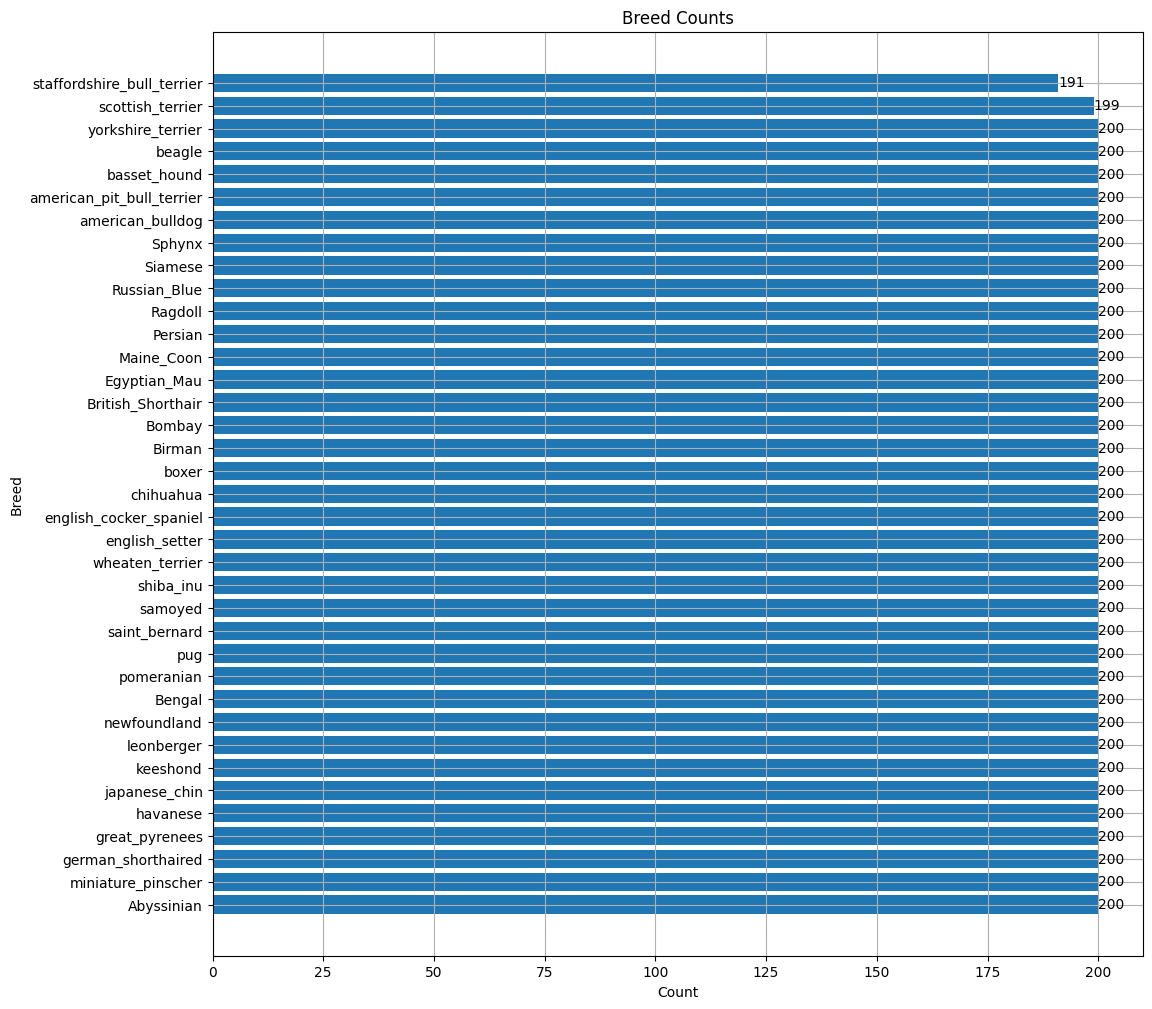

In [28]:
# Plot the distribution of breeds in the dataset
breed_counts = df['breed'].value_counts()

plt.figure(figsize=(12,12))
bars = plt.barh(breed_counts.index, breed_counts.values)

for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height() / 2, str(width), ha='left', va='center')

plt.ylabel('Breed')
plt.xlabel('Count')
plt.title('Breed Counts')
plt.grid()
plt.show()

- Analise the data to Multiclass classification

In [29]:
# unique breeds
print(len(df['species'].unique()))
print(df['species'].unique())


2
['cat' 'dog']


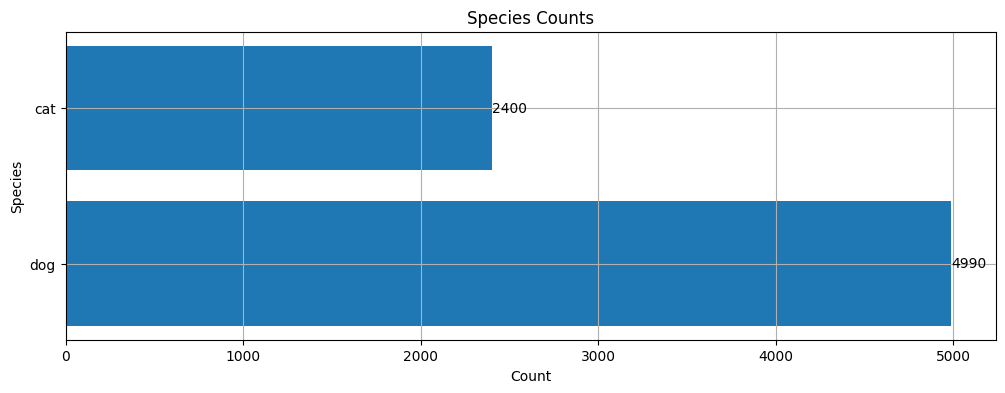

In [30]:
# Plot the distribution of species in the dataset
species_counts = df['species'].value_counts()

plt.figure(figsize=(12,4))
bars = plt.barh(species_counts.index, species_counts.values)

for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height() / 2, str(width), ha='left', va='center')


plt.ylabel('Species')
plt.xlabel('Count')
plt.title('Species Counts')
plt.grid()
plt.show()


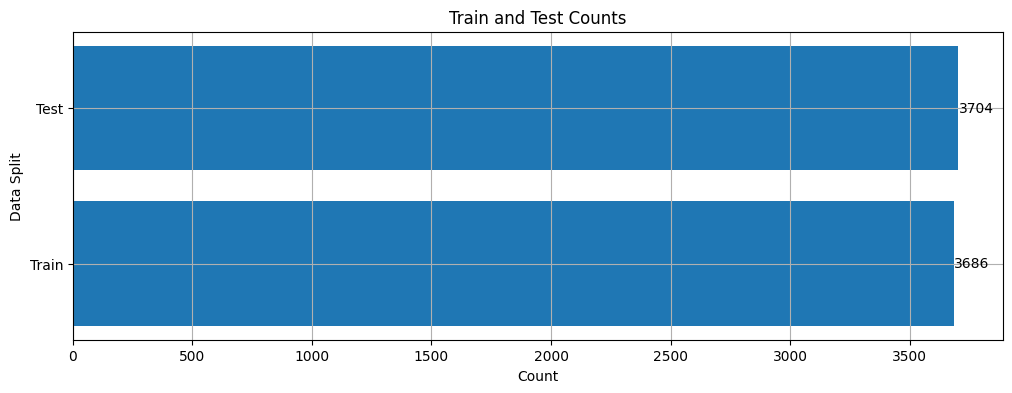

In [31]:
train_counts = len(df[df['foldTrain'] == True])
test_counts = len(df[df['foldTrain'] == False])

# Plot the distribution of training and testing
plt.figure(figsize=(12,4))
labels = ['Train', 'Test']
counts = [train_counts, test_counts]

bars = plt.barh(labels, counts)

for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height() / 2, str(width), ha='left', va='center')


plt.xlabel('Count')
plt.ylabel('Data Split')
plt.title('Train and Test Counts')
plt.grid()
plt.show()

# print(train_counts, test_counts)


## 3. Data Generators 

Deste ponto, foram criadas duas pastas (species e breeds), que irão ter as imagens de treino e de teste separadas de acordo com o problema de classificação (binário ou multi-classe).

In [35]:
D = pickle.load(open("Oxford-IIIT-Pet_Dics.p","rb"))

classDic = D['classDic']
filesDic = D['filesDic']
del D # delete D to free memory

def createFolders(classDic):
    """
    Creates the folders to store the images
    """
    for breed in list(classDic.keys()):
        # Breeds
        trainPath = os.path.join('./breeds/train/' + breed)
        if not os.path.exists(trainPath):
            os.makedirs('./breeds/train/' + breed)

        testPath = os.path.join('./breeds/test/' + breed)
        if not os.path.exists(testPath):
            os.makedirs('./breeds/test/' + breed)

        # Dogs
        trainPath = os.path.join('./species/train/dog')
        if not os.path.exists(trainPath):
            os.makedirs('./species/train/dog')

        testPath = os.path.join('./species/test/dog')
        if not os.path.exists(testPath):
            os.makedirs('./species/test/dog')

        # Cats
        trainPath = os.path.join('./species/train/cat')
        if not os.path.exists(trainPath):
            os.makedirs('./species/train/cat')

        testPath = os.path.join('./species/test/cat')
        if not os.path.exists(testPath):
            os.makedirs('./species/test/cat')

def splitData(filesDic, t='breed'):
    X1 = [] 
    X2 = [] 
    y1 = []
    y2 = []
    
    i = 1
    size = len(list(filesDic.keys()) )
    for imgName in list(filesDic.keys()):
        
        img = keras.preprocessing.image.load_img('images/' + imgName)
        foldTrain = filesDic.get(imgName).get('foldTrain')

        path = 'breeds' if t=='breed' else 'species'
        if t in filesDic.get(imgName).keys():
            p = './' + str(path) +'/' + ('train/' if foldTrain else 'test/') + filesDic.get(imgName).get(str(t)) +  '/' + imgName
            keras.preprocessing.image.save_img(p, img)
        
        else:
            print("Erro:", t)


createFolders(classDic)

splitData(filesDic, t='breed') # Multi-class classification3

splitData(filesDic, t='species') # Binary classification

folder = './Models/'
os.makedirs(folder, exist_ok=True)

##### 3.1 Data Generators for binary classification

In [38]:
# Data Generators for binary classification

# Data Generators for binary classification
speciesDir = './species/'

# Binary classification
speciesGen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Binary classification with augumentation
speciesGenAug = ImageDataGenerator(preprocessing_function=preprocess_input,
                                #    rescale = 1./255
                                   rotation_range=30,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode="nearest")

# speciesGenAug = ImageDataGenerator(rescale = 1./255, rotation_range=30, width_shift_range=0.2,
#                                   height_shift_range=0.2, shear_range=0.2,
#                                   horizontal_flip=True, fill_mode="nearest"
# )

# dados de treino
speciesTrainGen = speciesGen.flow_from_directory(directory=speciesDir + "train/",
                                                 target_size=image_size,
                                                 class_mode="categorical",
                                                 batch_size=32)

# dados de treino com augumentation
speciesTrainGenAug = speciesGenAug.flow_from_directory(directory=speciesDir + "train/",
                                                       target_size=image_size,
                                                       class_mode="categorical",
                                                       batch_size=32)

# dados de teste
speciesTestGen = speciesGen.flow_from_directory(directory=speciesDir + "test/",
                                                target_size=image_size,
                                                class_mode="categorical",
                                                batch_size=32, shuffle=False)



Found 3686 images belonging to 2 classes.
Found 3686 images belonging to 2 classes.
Found 3704 images belonging to 2 classes.


##### 3.2 Data Generators for multiclasse classification

In [37]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data Generators for multiclasse classification
breedsDir = './breeds/'

# multi-class classification
breedsGen = ImageDataGenerator(preprocessing_function=preprocess_input)

# multi-class classification with data argumetation
breedsGenAug = ImageDataGenerator(preprocessing_function=preprocess_input,
                                  rotation_range=30,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  fill_mode="nearest") #constant, nearest, reflect, wrap
                                  
# dados de treino
breedsTrainGen = breedsGen.flow_from_directory(directory=breedsDir + "train/",
                                               target_size=image_size,
                                               class_mode="categorical",
                                               batch_size=32)
# dados de treino com augumentation
breedsTrainGenAug = breedsGenAug.flow_from_directory(directory=breedsDir + "train/",
                                                     target_size=image_size,
                                                     class_mode="categorical",
                                                     batch_size=32)
# dados de teste
breedsTestGen = breedsGen.flow_from_directory(directory=breedsDir + "test/",
                                              target_size=image_size,
                                              class_mode="categorical",
                                              batch_size=32, shuffle=False)

# data: breedsTrainGen, breedsTrainGenAug, breedsTestGen

Found 3686 images belonging to 37 classes.
Found 3686 images belonging to 37 classes.
Found 3704 images belonging to 37 classes.


#### Explore the data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

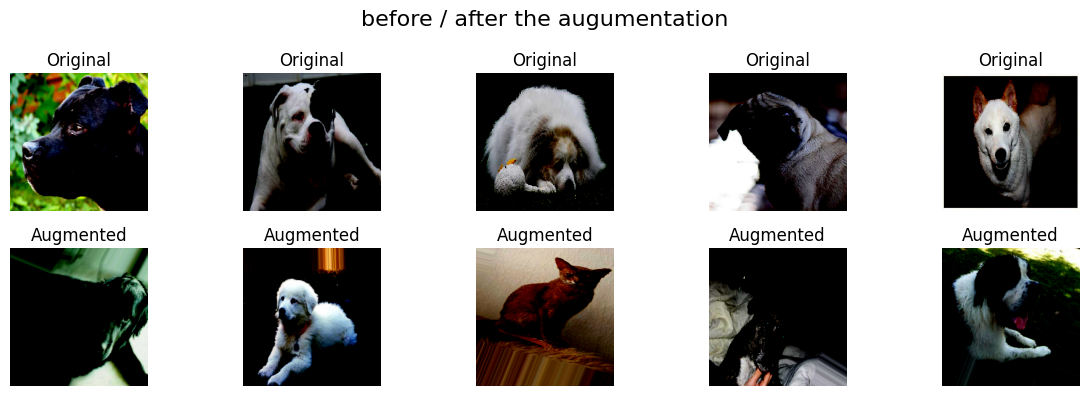

In [39]:
import matplotlib.pyplot as plt


# Selecionar algumas amostras do conjunto de dados original
original_samples = next(iter(breedsTrainGen))

# Selecionar algumas amostras do conjunto de dados com data augmentation
augmented_samples = next(iter(breedsTrainGenAug))

# Configurar a exibição das imagens
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(12, 4))
fig.suptitle('before / after the augumentation', fontsize=16)
# fig.subplots_adjust(top=0.9, bottom=0.1, left=0.05, right=0.95, hspace=0.5, wspace=0.9)


# Plotar as imagens originais
for i, sample in enumerate(original_samples[0][:5]):
    axs[0, i].set_title('Original')
    axs[0, i].imshow(sample)
    axs[0, i].axis('off')


# Plotar as imagens com data augmentation
for i, sample in enumerate(augmented_samples[0][:5]):
    # speciesGen original_samples
    # sample = speciesGen.flow(np.array([sample]), batch_size=1).next().squeeze()
    axs[1, i].set_title('Augmented')
    axs[1, i].imshow(sample)
    axs[1, i].axis('off')

# Ajustar o espaçamento entre as imagens
plt.tight_layout()

# Exibir o plot
plt.show()


## 5. Treinos e avaliacões

Para redimensionar as imagens, usou-se inicialmente o shape de 128 por 128 visto ser um valor padrão do modelo Mobilev2. No entanto, como os resultados iniciais não estavam a ter o melhor desempenho, decidimos aumentar o tamanho para 224 por 224. Com este tamanho, comecou-se a ter melhores resultados, e por isso manteve-se este shape, apesar de os modelos terem sido alterados posteriormente.

In [36]:
input_shape = (224, 224, 3)
image_size = input_shape[:2]

print("Input shape:", input_shape)
print("Image size:", image_size)

Input shape: (224, 224, 3)
Image size: (224, 224)


In [40]:
epochs = 30
steps_per_epoch = 100
validation_steps = 50
batch_size = 32


def plot_history(h, nome_classificador):

    fig, (acc, loss) = plt.subplots(1, 2, figsize=(10, 4))
    fig.suptitle(nome_classificador, fontsize=16)
    
    acc.plot(h['accuracy'], label='Training Accuracy')
    acc.plot(h['val_accuracy'], label='Validation Accuracy')
    acc.set_title('Model Accuracy')
    acc.set_xlabel('Epoch')
    acc.set_ylabel('Accuracy')
    acc.legend()
    acc.grid(True)
    acc.set_ylim([0,1])

    loss.plot(h['loss'], label='Training Loss')
    loss.plot(h['val_loss'], label='Validation Loss')
    loss.set_title('Model Loss')
    loss.set_xlabel('Epoch')
    loss.set_ylabel('Loss')
    loss.legend()
    loss.grid(True)


def plot_roc_pr(y_true, y_pred, y_pred_classes,
                nome_classificador='nome_classificador'): 

    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred_classes)
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    pr_auc = auc(recall, precision)
    
    # add roc point and pr point
    cm1 = confusion_matrix(y_true, y_pred_classes)
    fpP1 = cm1[0,1]/(cm1[0,1]+cm1[0,0])
    tpP1 = cm1[1,1]/(cm1[1,1]+cm1[1,0])

    recallP1 = cm1[1,1]/(cm1[1,1]+cm1[1,0])
    precisionP1 = cm1[1,1]/(cm1[1,1]+cm1[0,1])

    
    threshold = thresholds[np.argmax(np.abs(fpr - tpr))]
    print(threshold)
    y2_pred2 = (y_pred > threshold)
    cm2 = confusion_matrix(y_true, y2_pred2)
    fpP2 = cm2[0,1]/(cm2[0,1]+cm2[0,0])
    tpP2 = cm2[1,1]/(cm2[1,1]+cm2[1,0])

    recallP2 = cm2[1,1]/(cm2[1,1]+cm2[1,0])
    precisionP2 = cm2[1,1]/(cm2[1,1]+cm2[0,1])


    fig, (roc, pr) = plt.subplots(1, 2, figsize=(10, 4))
    fig.suptitle(nome_classificador, fontsize=16)

    roc.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    roc.plot([0, 1], [0, 1], 'k--')


    roc.plot(fpP1, tpP1, marker='o', markersize=5, color="red", label='Operational Point')
    roc.plot(fpP2, tpP2, marker='o', markersize=5, color="blue", label='Calibrated Operational Point')
    
    roc.set_title('ROC curve')
    roc.set_xlabel('False Positive Rate')
    roc.set_ylabel('True Positive Rate')
    roc.legend()
    roc.grid(True)
    roc.set_xlim([-0.1, 1.1])
    roc.set_ylim([-0.1, 1.1])

    pr.plot(recall, precision, label='Precision-Recall curve ( Recall = %0.2f)' % pr_auc)
    pr.plot(recallP1, precisionP1, marker='o', markersize=5, color="red", label='Operational Point')
    pr.plot(recallP2, precisionP2, marker='o', markersize=5, color="blue", label='Calibrated Operational Point')
    
    pr.set_title('Precision-Recall curve')
    pr.set_xlabel('Recall')
    pr.set_ylabel('Precision')
    pr.legend()
    pr.grid(True)
    pr.set_xlim([-0.1, 1.1])
    pr.set_ylim([-0.1, 1.1])

    plt.show()
    return cm2, y2_pred2
    

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cmN = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig = plt.figure(figsize=(6.5, 6.5))
    plt.imshow(cm, interpolation='none', cmap=cmap)
    plt.title(title)
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0, ha='right')
    plt.yticks(tick_marks, classes)

    fmt = 'd' #'.2f' if normalize else 'd'
    fmtN = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt) + '\n (' + format(cmN[i, j]*100, fmtN) + '%)',
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    # return fig


def metrics(y_true, y_pred_classes, 
            nome_classificador='nome_classificador'):
    # Calcular as métricas
    accuracy = accuracy_score(y_true, y_pred_classes)
    num_erros = len(y_true) - np.sum(y_true == y_pred_classes)
    precision = precision_score(y_true, y_pred_classes)
    recall = recall_score(y_true, y_pred_classes)
    f1 = f1_score(y_true, y_pred_classes)

    # Criar o DataFrame
    df_metrics = pd.DataFrame({
        'Accuracy': [round(accuracy, 2)],
        'N. Erros': [num_erros],
        'Precision': [round(precision, 2)],
        'Recall': [round(recall, 2)],
        'F1-score': [round(f1, 2)]
    }, index=[nome_classificador])

    # Imprimir o DataFrame
    print(df_metrics.head())


def evaluate(logs, model, TestGen, nome_classificador):
    y_pred = model.predict(TestGen)
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    # select max value from predictions
    y_pred = np.max(y_pred, axis=1)
    for i, val in enumerate(y_pred_classes):
        if val == 0:
            y_pred[i] = 1 - y_pred[i]

    y_true = TestGen.classes
    cm1 = confusion_matrix(y_true, y_pred_classes)


    plot_history(logs.history, nome_classificador)
    cm2, y2_pred2 = plot_roc_pr(y_true, y_pred, y_pred_classes, nome_classificador)
    plot_confusion_matrix(cm2, 
                          classes=TestGen.class_indices.keys())
    metrics(y_true, y2_pred2, nome_classificador)


### 5.1 Binary (Species)

##### 5.1.1 - Without data augmentation

- Network from Scratch

In [43]:

speciesCnn = models.Sequential([
    layers.Conv2D(8, (5, 5), activation='relu', padding='same', input_shape=input_shape),
    # layers.Conv2D(8, (3, 3), activation='relu', padding='same'),
    layers.AveragePooling2D((2, 2)),
    layers.Conv2D(16, (5, 5), activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.AveragePooling2D((2, 2)),
    #layers.Conv2D(32, (3, 3), activation='relu'),
    layers.Conv2D(64, (3, 3), activation='relu'),

    layers.Flatten(),
    layers.Dense(64, activation='relu'), # 64
    layers.Dense(2, activation='softmax')  # 2 species
])

# compile model
speciesCnn.compile(optimizer= "nadam", loss='categorical_crossentropy', 
                   metrics=['accuracy'])

print(speciesCnn.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 8)       608       
                                                                 
 average_pooling2d (AverageP  (None, 112, 112, 8)      0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 108, 108, 16)      3216      
                                                                 
 dropout (Dropout)           (None, 108, 108, 16)      0         
                                                                 
 batch_normalization (BatchN  (None, 108, 108, 16)     64        
 ormalization)                                                   
                                                                 
 average_pooling2d_1 (Averag  (None, 54, 54, 16)       0

In [45]:
%%time
# CNN from scratch without data augmentation

best_speciesCnn = os.path.join(folder, 'best_speciesCnn.h5')


early_stop = keras.callbacks.EarlyStopping(monitor='accuracy', 
                                           patience=5, 
                                           restore_best_weights=True)

best_model = keras.callbacks.ModelCheckpoint(best_speciesCnn, 
                                             monitor='val_loss', 
                                             save_best_only=True)


logspeciesCnn = speciesCnn.fit(speciesTrainGen,
                            #   steps_per_epoch = speciesTrainGenAug.n / batch_size,
                            #   validation_steps = speciesTestGen.n / batch_size,
                              epochs=30,
                              validation_data=speciesTestGen,
                              callbacks=[early_stop, best_model]
                              )


# loaded_model = load_model(best_speciesCnn)

Epoch 1/30
116/116 [==============================] - 9s 79ms/step - loss: 0.3369 - accuracy: 0.8595 - val_loss: 0.6179 - val_accuracy: 0.6760
Epoch 2/30
116/116 [==============================] - 8s 72ms/step - loss: 0.2322 - accuracy: 0.9094 - val_loss: 0.7105 - val_accuracy: 0.6058
Epoch 3/30
116/116 [==============================] - 8s 72ms/step - loss: 0.1541 - accuracy: 0.9471 - val_loss: 0.7122 - val_accuracy: 0.7195
Epoch 4/30
116/116 [==============================] - 8s 73ms/step - loss: 0.0758 - accuracy: 0.9794 - val_loss: 0.8981 - val_accuracy: 0.7017
Epoch 5/30
116/116 [==============================] - 9s 80ms/step - loss: 0.0599 - accuracy: 0.9810 - val_loss: 2.1929 - val_accuracy: 0.6874
Epoch 6/30
116/116 [==============================] - 9s 81ms/step - loss: 0.0655 - accuracy: 0.9791 - val_loss: 1.0658 - val_accuracy: 0.7100
Epoch 7/30
116/116 [==============================] - 9s 77ms/step - loss: 0.0214 - accuracy: 0.9965 - val_loss: 1.3120 - val_accuracy: 0.7138

116/116 [==============================] - 4s 36ms/step
0.908778


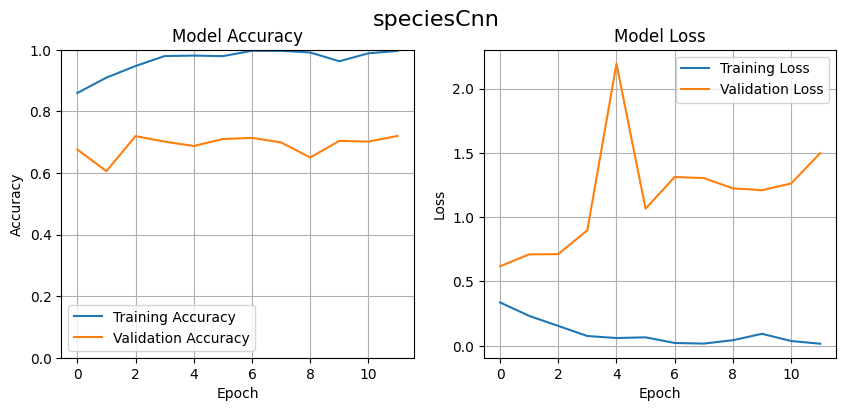

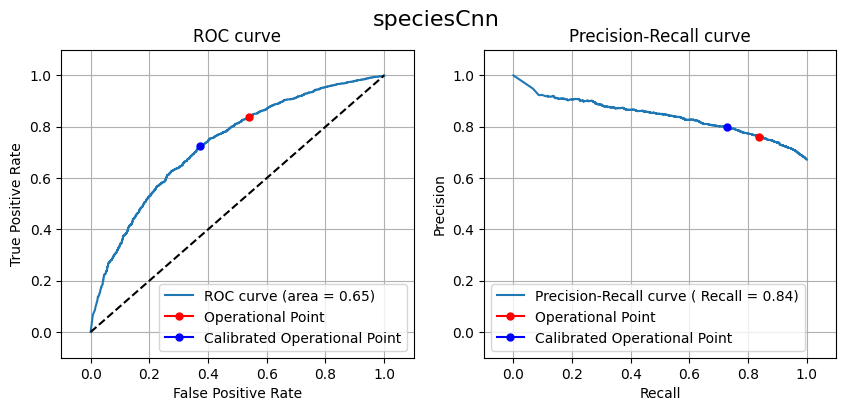

            Accuracy  N. Erros  Precision  Recall  F1-score
speciesCnn      0.69      1133        0.8    0.73      0.76


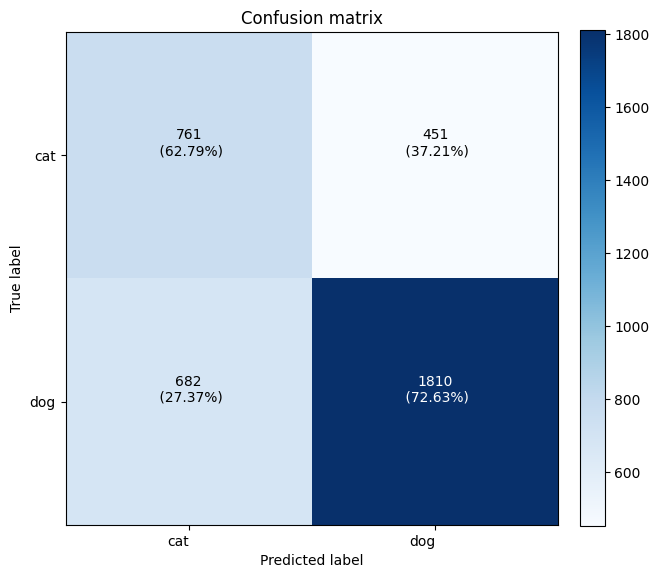

In [46]:
evaluate(logspeciesCnn, speciesCnn, speciesTestGen, 'speciesCnn')

O que se pode observar é que:
- Apesar do nosso modelo ter Dropout e Normalization, continuou a existir overfitting;
- Como se pode observar no gráfico Model Accuracy, o modelo parou nas 12ª iteração visto que as últimas 5 épocas o modelo não conseguiu melhorar.

#### Pre-trained Network

Para testar um modelo de uma rede pré-treinada, decidiu-se usar a rede MobileNetV2. Isto deveu-se a que é uma rede que possui aproximadamente 4.3 milhões de parâmetros e torna o treino mais rápido em comparação com outras redes. É uma das Aplicações do Keras que possui menos parâmetros, como podemos ver em https://keras.io/api/applications/.

In [48]:
## Com MobileNetV2 network without data augmentation
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input

mn_binary = MobileNetV2(weights='imagenet',
                  input_shape=(224, 224, 3))

mn_binary.trainable = False

#mn2.summary()

species_binary_Cnn = models.Sequential()
species_binary_Cnn.add(mn_binary)
species_binary_Cnn.add(layers.Flatten())
species_binary_Cnn.add(layers.Dense(2, activation='softmax'))  # 37 breeds

species_binary_Cnn.summary()

species_binary_Cnn.compile(optimizer="nadam",
                     loss="categorical_crossentropy",
                     metrics=["accuracy"])



14536120/14536120 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 1000)             3538984   
 ional)                                                          
                                                                 
 flatten_1 (Flatten)         (None, 1000)              0         
                                                                 
 dense_2 (Dense)             (None, 2)                 2002      
                                                                 
Total params: 3,540,986
Trainable params: 2,002
Non-trainable params: 3,538,984
_________________________________________________________________


In [49]:
%%time
best_species_binary_Cnn = os.path.join(folder, 'best_species_binary_Cnn.h5')


early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                           patience=5, 
                                           restore_best_weights=True)

best_model = keras.callbacks.ModelCheckpoint(best_species_binary_Cnn, 
                                             monitor='val_loss', 
                                             save_best_only=True)


logspecies_binary_Cnn = species_binary_Cnn.fit(speciesTrainGen,
                       epochs=30,
                       validation_data=speciesTestGen,
                       callbacks=[early_stop, best_model]
                       )

# loaded_model = load_model(best_species_binary_Cnn)

Epoch 1/30
116/116 [==============================] - 12s 88ms/step - loss: 0.6544 - accuracy: 0.6788 - val_loss: 0.6125 - val_accuracy: 0.7343
Epoch 2/30
116/116 [==============================] - 10s 89ms/step - loss: 0.5799 - accuracy: 0.7320 - val_loss: 0.5468 - val_accuracy: 0.7616
Epoch 3/30
116/116 [==============================] - 9s 78ms/step - loss: 0.5222 - accuracy: 0.8120 - val_loss: 0.4941 - val_accuracy: 0.8548
Epoch 4/30
116/116 [==============================] - 9s 75ms/step - loss: 0.4752 - accuracy: 0.8671 - val_loss: 0.4508 - val_accuracy: 0.8963
Epoch 5/30
116/116 [==============================] - 9s 78ms/step - loss: 0.4356 - accuracy: 0.8961 - val_loss: 0.4135 - val_accuracy: 0.9177
Epoch 6/30
116/116 [==============================] - 9s 76ms/step - loss: 0.4016 - accuracy: 0.9164 - val_loss: 0.3808 - val_accuracy: 0.9357
Epoch 7/30
116/116 [==============================] - 9s 76ms/step - loss: 0.3713 - accuracy: 0.9303 - val_loss: 0.3518 - val_accuracy: 0.94

116/116 [==============================] - 5s 38ms/step
0.72069913


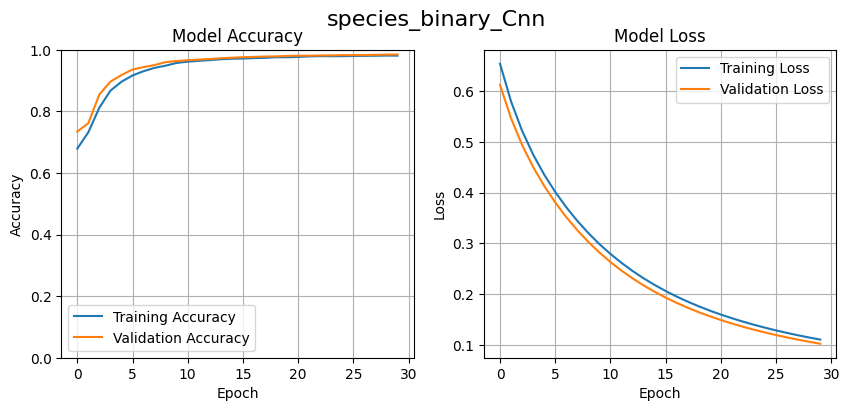

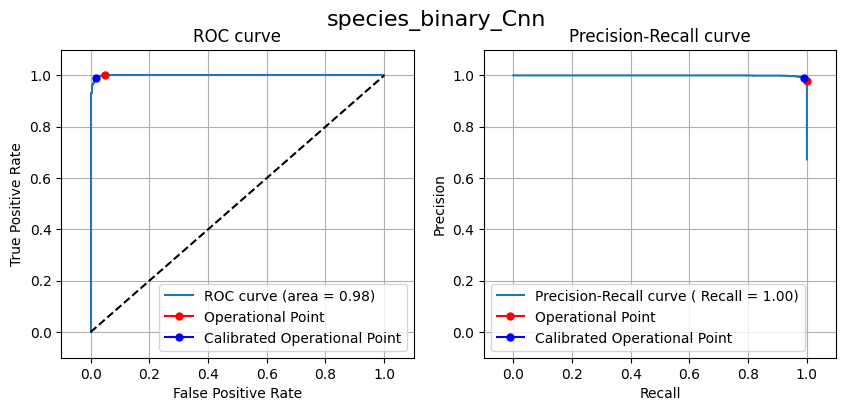

                    Accuracy  N. Erros  Precision  Recall  F1-score
species_binary_Cnn      0.99        46       0.99    0.99      0.99


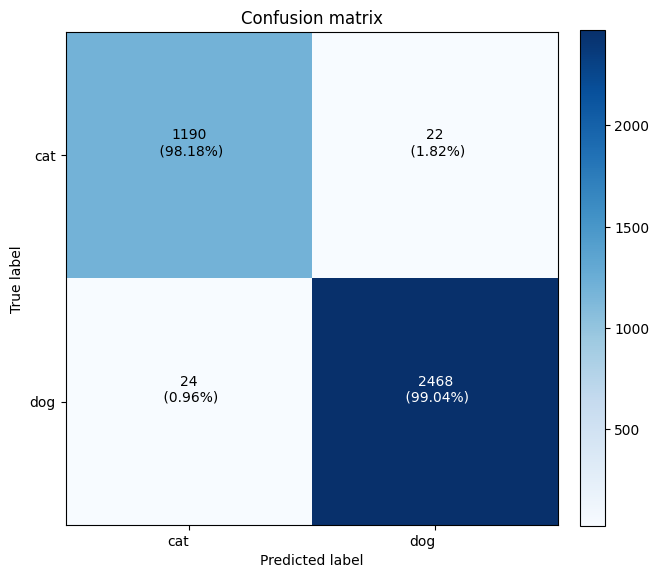

In [50]:
evaluate(logspecies_binary_Cnn, species_binary_Cnn, speciesTestGen, 'species_binary_Cnn')

Como este modelo é um modelo pré-treinado, teve resultados ótimos, como se pode observar na accuracy, e na matriz de confusão.

##### 5.1.2 - With data augmentation

De seguida, correu-se os mesmos modelos mas com os dados aumentados (data agumentation)

- Network from Scrath

In [54]:
speciesCnnAug = models.Sequential([
    layers.Conv2D(8, (5, 5), activation='relu', padding='same', input_shape=input_shape),
    # layers.Conv2D(8, (3, 3), activation='relu', padding='same'),
    layers.AveragePooling2D((2, 2)),
    layers.Conv2D(16, (5, 5), activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.AveragePooling2D((2, 2)),
    #layers.Conv2D(32, (3, 3), activation='relu'),
    layers.Conv2D(64, (3, 3), activation='relu'),

    layers.Flatten(),
    layers.Dense(64, activation='relu'), # 64
    layers.Dense(2, activation='softmax')  # 2 species

])

# compile model
speciesCnnAug.compile(optimizer= "nadam", loss='categorical_crossentropy', 
                      metrics=['accuracy'])

print(speciesCnnAug.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 224, 224, 8)       608       
                                                                 
 average_pooling2d_4 (Averag  (None, 112, 112, 8)      0         
 ePooling2D)                                                     
                                                                 
 conv2d_7 (Conv2D)           (None, 108, 108, 16)      3216      
                                                                 
 dropout_2 (Dropout)         (None, 108, 108, 16)      0         
                                                                 
 batch_normalization_2 (Batc  (None, 108, 108, 16)     64        
 hNormalization)                                                 
                                                                 
 average_pooling2d_5 (Averag  (None, 54, 54, 16)      

In [57]:
%%time
## CNN from scratch with data augmentation

best_speciesCnnAug = os.path.join(folder, 'best_speciesCnnAug.h5')


early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                           patience=5, 
                                           restore_best_weights=True)

best_model = keras.callbacks.ModelCheckpoint(best_speciesCnnAug, 
                                             monitor='val_loss', 
                                             save_best_only=True)



logspeciesCnnAug = speciesCnnAug.fit(speciesTrainGenAug,
                                    epochs=30,
                                    steps_per_epoch = speciesTrainGenAug.n / batch_size,
                                    validation_steps = speciesTestGen.n / batch_size,
                                    validation_data=speciesTestGen,
                                    callbacks=[early_stop, best_model])

# loaded_model = load_model(best_speciesCnnAug)

Epoch 1/30
115/115 [==============================] - 30s 250ms/step - loss: 1.1531 - accuracy: 0.6310 - val_loss: 0.6922 - val_accuracy: 0.5497
Epoch 2/30
115/115 [==============================] - 28s 244ms/step - loss: 0.6077 - accuracy: 0.6788 - val_loss: 0.6801 - val_accuracy: 0.6620
Epoch 3/30
115/115 [==============================] - 27s 231ms/step - loss: 0.5976 - accuracy: 0.6891 - val_loss: 0.6460 - val_accuracy: 0.7033
Epoch 4/30
115/115 [==============================] - 27s 233ms/step - loss: 0.5875 - accuracy: 0.6880 - val_loss: 0.5870 - val_accuracy: 0.6814
Epoch 5/30
115/115 [==============================] - 26s 225ms/step - loss: 0.5861 - accuracy: 0.6853 - val_loss: 0.5696 - val_accuracy: 0.7009
Epoch 6/30
115/115 [==============================] - 26s 226ms/step - loss: 0.5785 - accuracy: 0.6942 - val_loss: 0.5454 - val_accuracy: 0.7084
Epoch 7/30
115/115 [==============================] - 25s 221ms/step - loss: 0.5739 - accuracy: 0.7048 - val_loss: 0.5444 - val_ac

116/116 [==============================] - 4s 36ms/step
0.60891014


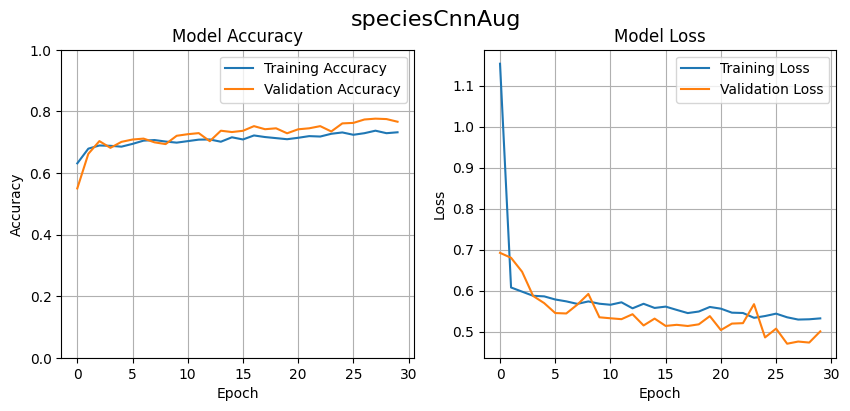

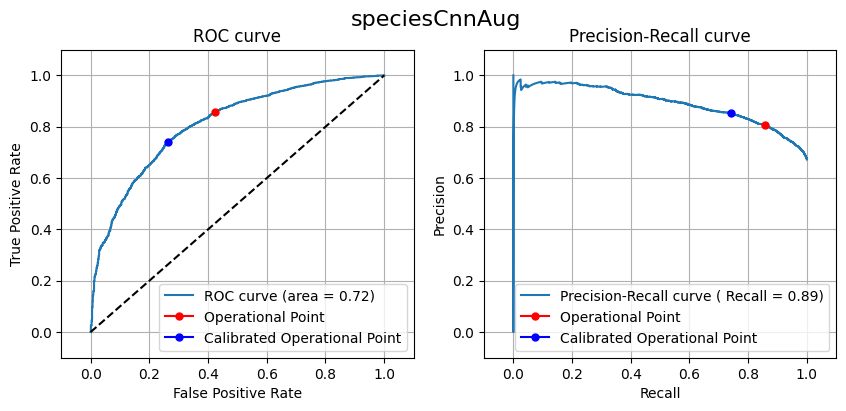

               Accuracy  N. Erros  Precision  Recall  F1-score
speciesCnnAug      0.74       963       0.85    0.74      0.79


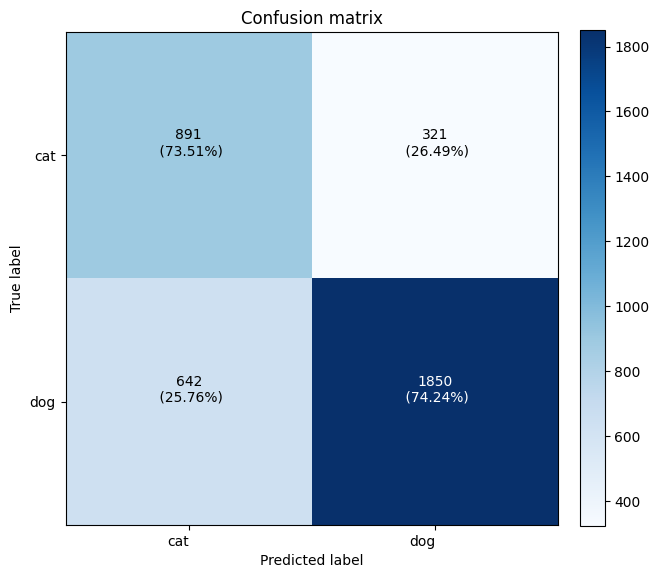

In [58]:
evaluate(logspeciesCnnAug, speciesCnnAug, 
         speciesTestGen, 'speciesCnnAug')

- Pre-trained Network

In [60]:
## Com MobileNetV2 network With data augmentation
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input

mn_binary_daug = MobileNetV2(weights='imagenet',
                  input_shape=(224, 224, 3))

mn_binary_daug.trainable = False

#mn2.summary()

species_binary_Cnn_daug = models.Sequential()
species_binary_Cnn_daug.add(mn_binary_daug)
species_binary_Cnn_daug.add(layers.Flatten())
species_binary_Cnn_daug.add(layers.Dense(2, activation='softmax'))  # 37 breeds

species_binary_Cnn_daug.summary()

species_binary_Cnn_daug.compile(optimizer="nadam",
                     loss="categorical_crossentropy",
                     metrics=["accuracy"])



Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 1000)             3538984   
 ional)                                                          
                                                                 
 flatten_4 (Flatten)         (None, 1000)              0         
                                                                 
 dense_7 (Dense)             (None, 2)                 2002      
                                                                 
Total params: 3,540,986
Trainable params: 2,002
Non-trainable params: 3,538,984
_________________________________________________________________


In [61]:
%%time
best_species_binary_Cnn_daug = os.path.join(folder, 'best_species_binary_Cnn_daug.h5')
#early_stop = keras.callbacks.EarlyStopping(monitor='accuracy', patience=10)
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                           patience=5, 
                                           restore_best_weights=True)

best_model = keras.callbacks.ModelCheckpoint(best_species_binary_Cnn_daug, 
                                             monitor='val_loss', 
                                             save_best_only=True)


# data: speciesTrainGen, speciesTrainGenAug, speciesTestGen
logspecies_binary_Cnn_daug = species_binary_Cnn_daug.fit(speciesTrainGenAug,
                                                        epochs=30,
                                                        validation_data=speciesTestGen,
                                                        callbacks=[early_stop, best_model])


# loaded_model = load_model(best_species_binary_Cnn_daug)

Epoch 1/30
116/116 [==============================] - 32s 259ms/step - loss: 0.6512 - accuracy: 0.6907 - val_loss: 0.6082 - val_accuracy: 0.7082
Epoch 2/30
116/116 [==============================] - 28s 242ms/step - loss: 0.5804 - accuracy: 0.7132 - val_loss: 0.5438 - val_accuracy: 0.7605
Epoch 3/30
116/116 [==============================] - 27s 233ms/step - loss: 0.5291 - accuracy: 0.7789 - val_loss: 0.4934 - val_accuracy: 0.8364
Epoch 4/30
116/116 [==============================] - 27s 232ms/step - loss: 0.4868 - accuracy: 0.8231 - val_loss: 0.4514 - val_accuracy: 0.8839
Epoch 5/30
116/116 [==============================] - 26s 226ms/step - loss: 0.4512 - accuracy: 0.8608 - val_loss: 0.4150 - val_accuracy: 0.9085
Epoch 6/30
116/116 [==============================] - 26s 225ms/step - loss: 0.4198 - accuracy: 0.8817 - val_loss: 0.3831 - val_accuracy: 0.9258
Epoch 7/30
116/116 [==============================] - 26s 225ms/step - loss: 0.3915 - accuracy: 0.8964 - val_loss: 0.3545 - val_ac

116/116 [==============================] - 5s 36ms/step
0.7626653


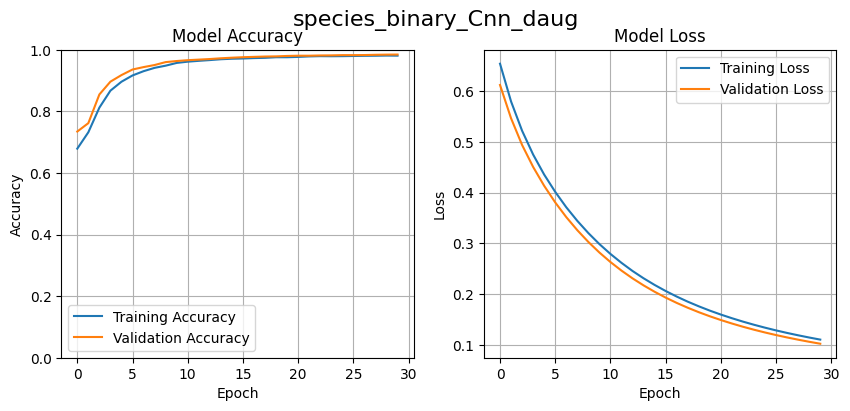

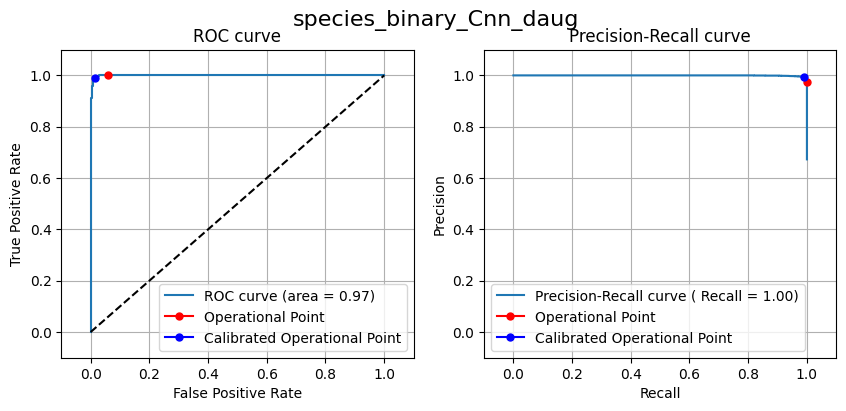

                         Accuracy  N. Erros  Precision  Recall  F1-score
species_binary_Cnn_daug      0.99        45       0.99    0.99      0.99


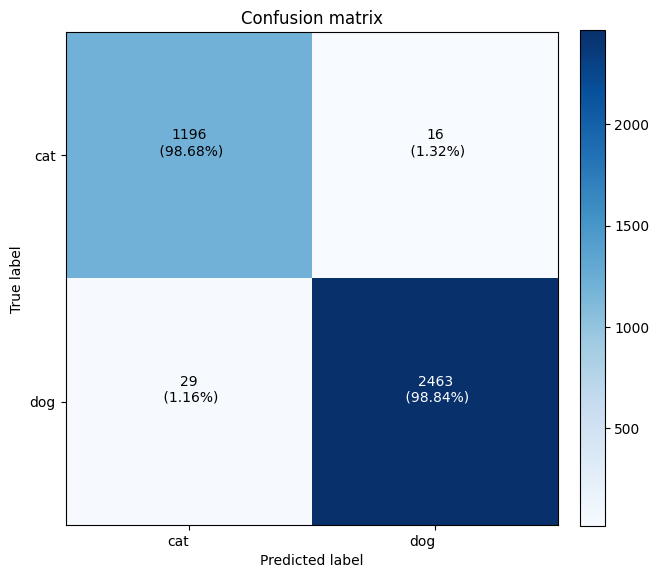

In [62]:
# evaluate(logs, model, TestGen, model_name)
evaluate(logspecies_binary_Cnn, species_binary_Cnn_daug, speciesTestGen, 'species_binary_Cnn_daug')

### 5.2 Multi-class (Breeds)

In [64]:
from sklearn.metrics import classification_report

def plot_confusion_matrix_multiclass(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    # if normalize:
    #     cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    #     title = "Normalized confusion matrix"
    # else:
    #     title = "Confusion matrix, without normalization"
    cmN = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig = plt.figure(figsize=(15, 25))
    plt.imshow(cm, interpolation='none', cmap=cmap)
    plt.title(title)
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, ha='right')
    plt.yticks(tick_marks, classes)

    fmt = 'd' #'.2f' if normalize else 'd'
    fmtN = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    # return fig


def metrics_multi(y_true, y_pred_classes, 
            nome_classificador='nome_classificador'):
    # summary: accuracy, number of erros, 
    # precision, recall, f1-score
    # plots: matriz de confusao, roc, precision-recall
    # y_pred = model.predict(X)
    # y_pred = np.argmax(y_pred, axis=1)
    # y_true = np.argmax(y, axis=1)

    # y_pred = model.predict(TestGen)
    # y_pred_classes = np.argmax(y_pred, axis=1)
    # y_true = TestGen.classes

    # print(classification_report(y_true, y_pred))
    # print(confusion_matrix(y_true, y_pred))
    
    # print('Total number of errors: ', np.sum(y2 != y_pred))
    # print('Accuracy: ', np.sum(y2 == y_pred) / y2.shape[0] * 100)
    # Calcular as métricas
    accuracy = accuracy_score(y_true, y_pred_classes)
    num_erros = len(y_true) - np.sum(y_true == y_pred_classes)
    precision = precision_score(y_true, y_pred_classes, average='macro')
    recall = recall_score(y_true, y_pred_classes, average='macro')
    f1 = f1_score(y_true, y_pred_classes, average='macro')

    # Criar o DataFrame
    df_metrics = pd.DataFrame({
        'Accuracy': [round(accuracy, 2)],
        'N. Erros': [num_erros],
        'Precision': [round(precision, 2)],
        'Recall': [round(recall, 2)],
        'F1-score': [round(f1, 2)]
    }, index=[nome_classificador])

    # Imprimir o DataFrame
    print(df_metrics.head())
    # Curva roc e ponto?
    # print(confusion_matrix(y_true, y_pred_classes))
    
    # Curva precision-recall e ponto?


def evaluate_multiclass(logs, model, TestGen, nome_classificador):
    # y_pred = model.predict(TestGen)
    # y_pred_classes = np.argmax(y_pred, axis=1)
    # y_true = TestGen.classes
    # cm1 = confusion_matrix(y_true, y_pred_classes)

    y_pred = model.predict(TestGen)
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    # select max value from predictions
    y_pred = np.max(y_pred, axis=1)
    for i, val in enumerate(y_pred_classes):
        if val == 0:
            y_pred[i] = 1 - y_pred[i]

    y_true = TestGen.classes
    cm1 = confusion_matrix(y_true, y_pred_classes)

    # Encontrar o ponto operacional (ROC)
    # idx_operating_point = np.argmax(tpr - fpr)
    # operating_point = (fpr[idx_operating_point], tpr[idx_operating_point])

    # Encontrar o ponto na curva Precision-Recall
    # idx_pr_point = np.argmax(precision - recall)
    # pr_point = (recall[idx_pr_point], precision[idx_pr_point])


    metrics_multi(y_true, y_pred_classes, nome_classificador)
    #classification_report(y_true, y_pred_classes)
    print("\n\nCLASSIFICATION REPORT\n")

    print(classification_report(y_true, y_pred_classes))
    print("\n\n\n")
    plot_history(logs.history, nome_classificador)
    #plot_roc_pr(y_true, y_pred_classes, nome_classificador)
    plot_confusion_matrix_multiclass(cm1, 
                          classes=TestGen.class_indices.keys())
    
    #classification_report(y_true, y_pred_classes)

In [65]:
# data: breedsTrainGen, breedsTrainGenAug, breedsTestGen

#### CNN from scratch

##### 5.2.1 - Without data augmentation

In [66]:
breedsCnn = models.Sequential([
    layers.Conv2D(16, (5, 5), activation='relu', padding='same', input_shape=input_shape),
    layers.Conv2D(16, (3, 3), activation='relu', padding='same'), #
    layers.AveragePooling2D((2, 2)),
    layers.Dropout(0.5),#
    layers.BatchNormalization(),#

    layers.Conv2D(32, (5, 5), activation='relu',  padding='same'), #
    layers.Conv2D(32, (3, 3), activation='relu',  padding='same'), #
    layers.AveragePooling2D((2, 2)),
    layers.Dropout(0.5),#
    layers.BatchNormalization(),#

    layers.Conv2D(32, (3, 3), activation='relu',  padding='same'), #
    layers.Conv2D(32, (3, 3), activation='relu',  padding='same'),
    layers.AveragePooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(37, activation='softmax') # 37 breeds


])


breedsCnn.compile(optimizer= "nadam", loss='categorical_crossentropy', metrics=['accuracy'])

print(breedsCnn.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 224, 224, 16)      1216      
                                                                 
 conv2d_10 (Conv2D)          (None, 224, 224, 16)      2320      
                                                                 
 average_pooling2d_6 (Averag  (None, 112, 112, 16)     0         
 ePooling2D)                                                     
                                                                 
 dropout_3 (Dropout)         (None, 112, 112, 16)      0         
                                                                 
 batch_normalization_3 (Batc  (None, 112, 112, 16)     64        
 hNormalization)                                                 
                                                                 
 conv2d_11 (Conv2D)          (None, 112, 112, 32)     

In [67]:
%%time
best_breedsCnn = os.path.join(folder, 'best_breedsCnn.h5')
#early_stop = keras.callbacks.EarlyStopping(monitor='accuracy', patience=10)
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                           patience=5, 
                                           restore_best_weights=True)

best_model = keras.callbacks.ModelCheckpoint(best_breedsCnn, 
                                             monitor='val_loss', 
                                             save_best_only=True)


## CNN from scratch without data augmentation

logbreedsCnn = breedsCnn.fit(breedsTrainGen,
                    epochs=30,
                    steps_per_epoch = breedsTrainGenAug.n / batch_size,
                    validation_steps = breedsTestGen.n / batch_size,
                    validation_data=breedsTestGen,
                    callbacks=[early_stop, best_model])


# loaded_model = load_model(best_breedsCnn)


Epoch 1/30
115/115 [==============================] - 28s 235ms/step - loss: 3.6987 - accuracy: 0.0231 - val_loss: 3.6109 - val_accuracy: 0.0270
Epoch 2/30
115/115 [==============================] - 8s 73ms/step - loss: 3.6129 - accuracy: 0.0195 - val_loss: 3.6109 - val_accuracy: 0.0270
Epoch 3/30
115/115 [==============================] - 8s 72ms/step - loss: 3.6114 - accuracy: 0.0228 - val_loss: 3.6110 - val_accuracy: 0.0270
Epoch 4/30
115/115 [==============================] - 8s 73ms/step - loss: 3.6113 - accuracy: 0.0231 - val_loss: 3.6110 - val_accuracy: 0.0267
Epoch 5/30
115/115 [==============================] - 8s 73ms/step - loss: 3.6113 - accuracy: 0.0220 - val_loss: 3.6110 - val_accuracy: 0.0267
Epoch 6/30
115/115 [==============================] - 8s 72ms/step - loss: 3.6167 - accuracy: 0.0214 - val_loss: 3.6110 - val_accuracy: 0.0270
CPU times: total: 1min 11s
Wall time: 1min 9s


116/116 [==============================] - 4s 35ms/step
           Accuracy  N. Erros  Precision  Recall  F1-score
breedsCnn      0.03      3604        0.0    0.03       0.0


CLASSIFICATION REPORT

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       101
           1       0.00      0.00      0.00       102
           2       0.00      0.00      0.00       100
           3       0.00      0.00      0.00       100
           4       0.00      0.00      0.00       100
           5       0.00      0.00      0.00       108
           6       0.00      0.00      0.00       100
           7       0.00      0.00      0.00       100
           8       0.00      0.00      0.00       101
           9       0.00      0.00      0.00       100
          10       0.00      0.00      0.00       100
          11       0.00      0.00      0.00       100
          12       0.00      0.00      0.00       100
          13       0.00      0.00      0.00 

C:\Users\goncalo\aaa\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\goncalo\aaa\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\goncalo\aaa\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\goncalo\aaa\venv\lib\site-packages\sklearn\metrics\_clas

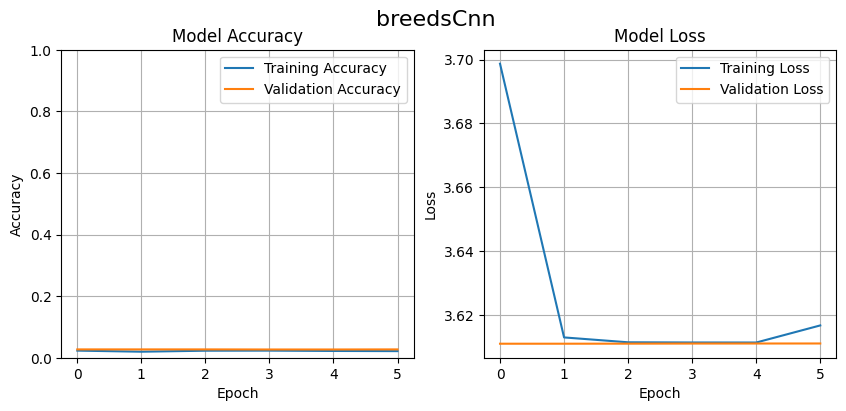

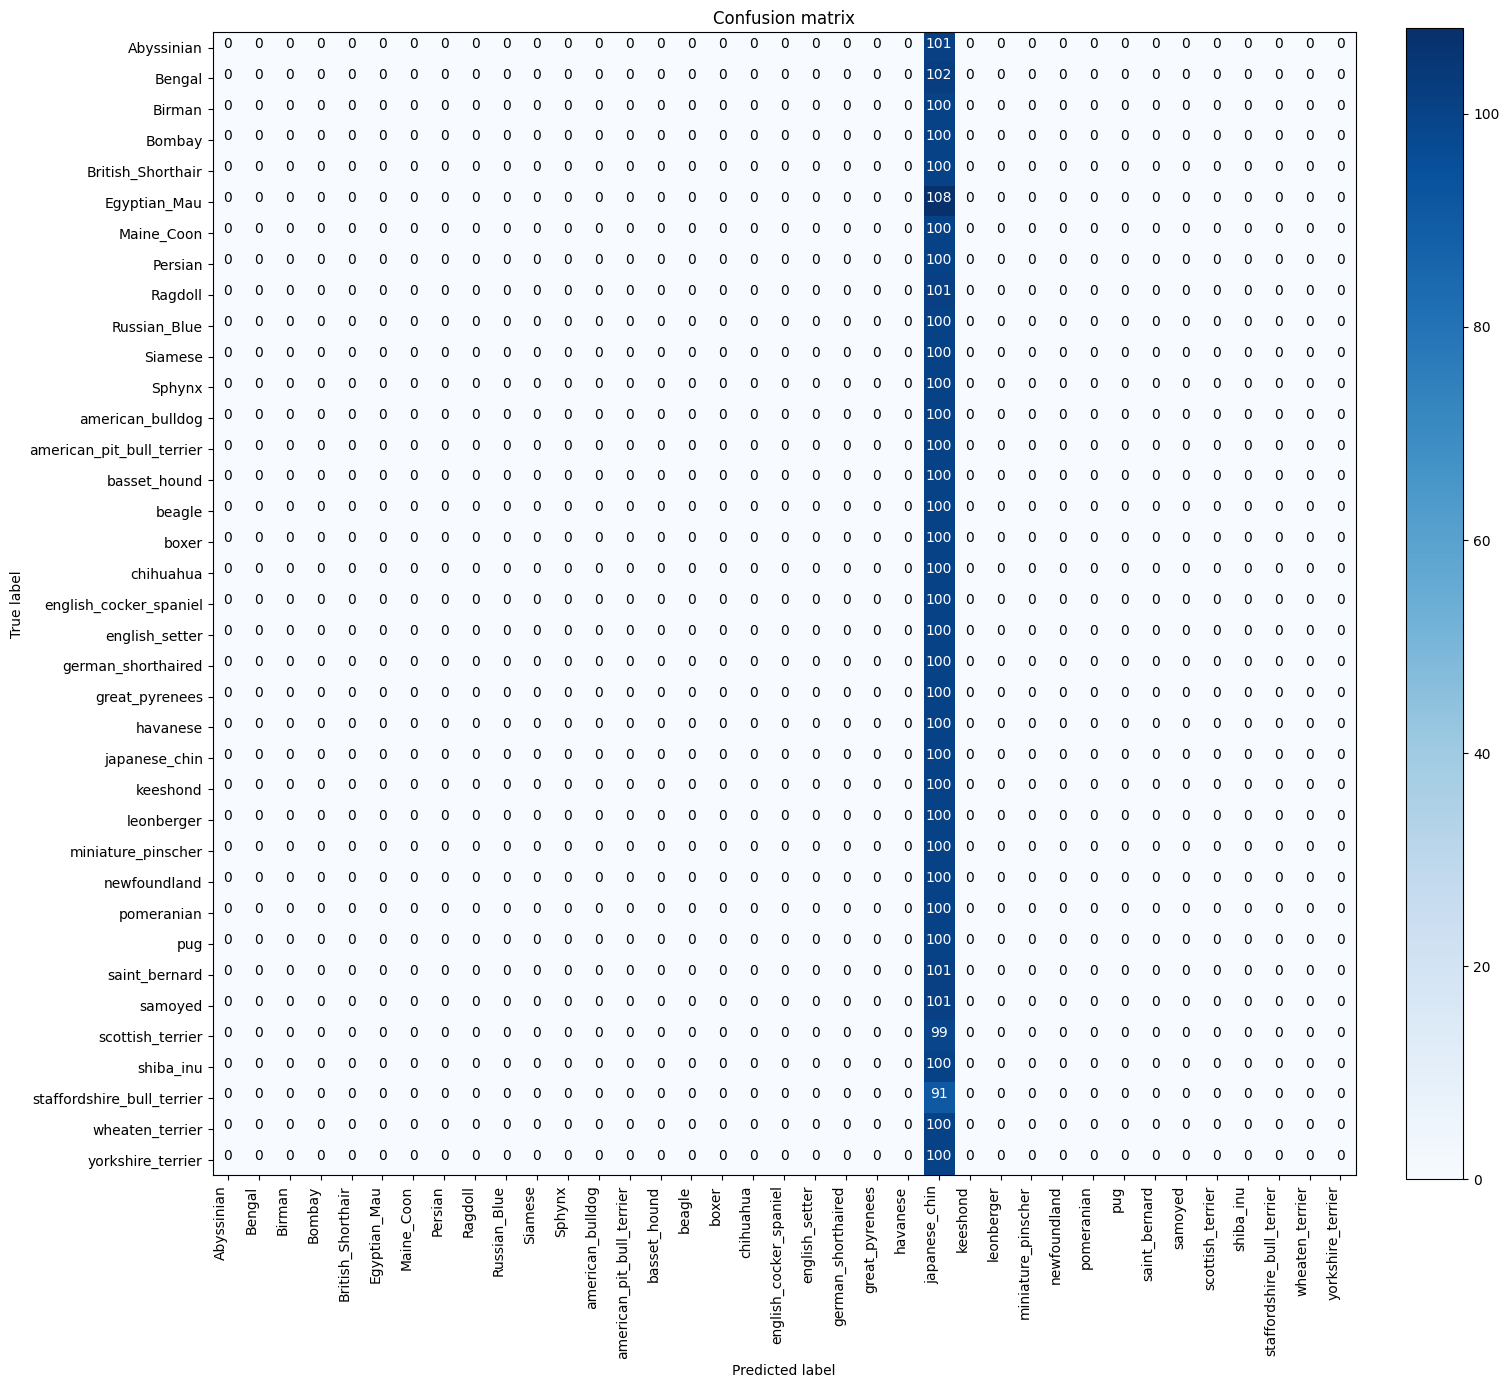

In [68]:
# Metricas
evaluate_multiclass(logbreedsCnn, breedsCnn, breedsTestGen, 'breedsCnn')

In [70]:
# treinar rede mais simples
breedsCnnSimples = models.Sequential([
    layers.Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=input_shape),
    layers.MaxPool2D((2, 2)),
    layers.Dropout(0.3),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPool2D((2, 2)),
    # Flatten(),
    layers.Flatten(),
    layers.Dense(37, activation='softmax'), # 37 classes

])

breedsCnnSimples.compile(optimizer= "nadam", loss='categorical_crossentropy', metrics=['accuracy'])

print(breedsCnnSimples.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 dropout_5 (Dropout)         (None, 112, 112, 16)      0         
                                                                 
 conv2d_16 (Conv2D)          (None, 110, 110, 64)      9280      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 55, 55, 64)       0         
 2D)                                                             
                                                                 
 flatten_6 (Flatten)         (None, 193600)           

In [71]:
%%time
best_breedsCnnSimples = os.path.join(folder, 'best_breedsCnnSimples.h5')

#early_stop = keras.callbacks.EarlyStopping(monitor='accuracy', patience=10)
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                           patience=5, 
                                           restore_best_weights=True)

best_model = keras.callbacks.ModelCheckpoint(best_breedsCnnSimples, 
                                             monitor='val_loss', 
                                             save_best_only=True)


## CNN from scratch without data augmentation
logbreedsCnnSimples = breedsCnnSimples.fit(breedsTrainGen,
                    epochs=30,
                    validation_data=breedsTestGen,
                    callbacks=[early_stop, best_model])


# loaded_model = load_model(best_breedsCnnSimples)


Epoch 1/30
116/116 [==============================] - 11s 88ms/step - loss: 5.6030 - accuracy: 0.0567 - val_loss: 3.5284 - val_accuracy: 0.0721
Epoch 2/30
116/116 [==============================] - 10s 82ms/step - loss: 3.0768 - accuracy: 0.1728 - val_loss: 3.3781 - val_accuracy: 0.1126
Epoch 3/30
116/116 [==============================] - 10s 86ms/step - loss: 2.0989 - accuracy: 0.4267 - val_loss: 3.3771 - val_accuracy: 0.1104
Epoch 4/30
116/116 [==============================] - 10s 85ms/step - loss: 0.5030 - accuracy: 0.8858 - val_loss: 4.2132 - val_accuracy: 0.0988
Epoch 5/30
116/116 [==============================] - 9s 81ms/step - loss: 0.0549 - accuracy: 0.9929 - val_loss: 4.7829 - val_accuracy: 0.1164
Epoch 6/30
116/116 [==============================] - 10s 84ms/step - loss: 0.0142 - accuracy: 0.9986 - val_loss: 4.8767 - val_accuracy: 0.1231
Epoch 7/30
116/116 [==============================] - 8s 73ms/step - loss: 0.0039 - accuracy: 1.0000 - val_loss: 5.0731 - val_accuracy: 0

116/116 [==============================] - 4s 38ms/step
                  Accuracy  N. Erros  Precision  Recall  F1-score
breedsCnnSimples      0.11      3295       0.16    0.11      0.11


CLASSIFICATION REPORT

              precision    recall  f1-score   support

           0       0.17      0.08      0.11       101
           1       0.16      0.22      0.18       102
           2       0.00      0.00      0.00       100
           3       0.73      0.19      0.30       100
           4       0.17      0.12      0.14       100
           5       0.36      0.27      0.31       108
           6       0.15      0.10      0.12       100
           7       0.12      0.17      0.14       100
           8       0.15      0.05      0.07       101
           9       0.18      0.10      0.13       100
          10       0.29      0.02      0.04       100
          11       0.09      0.06      0.07       100
          12       0.18      0.08      0.11       100
          13       0.04      0

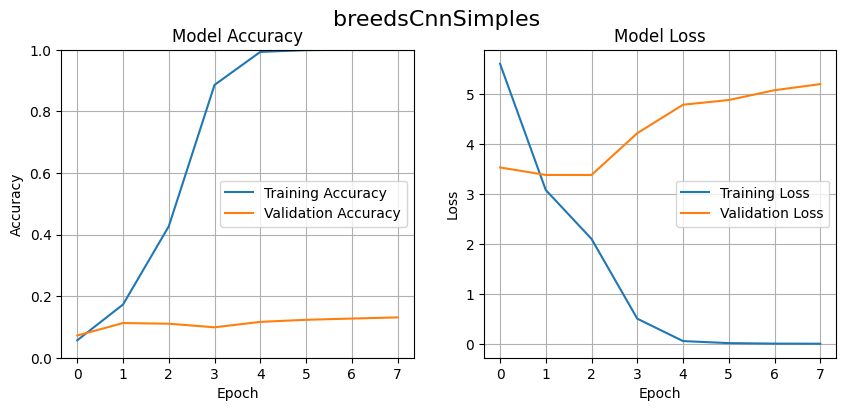

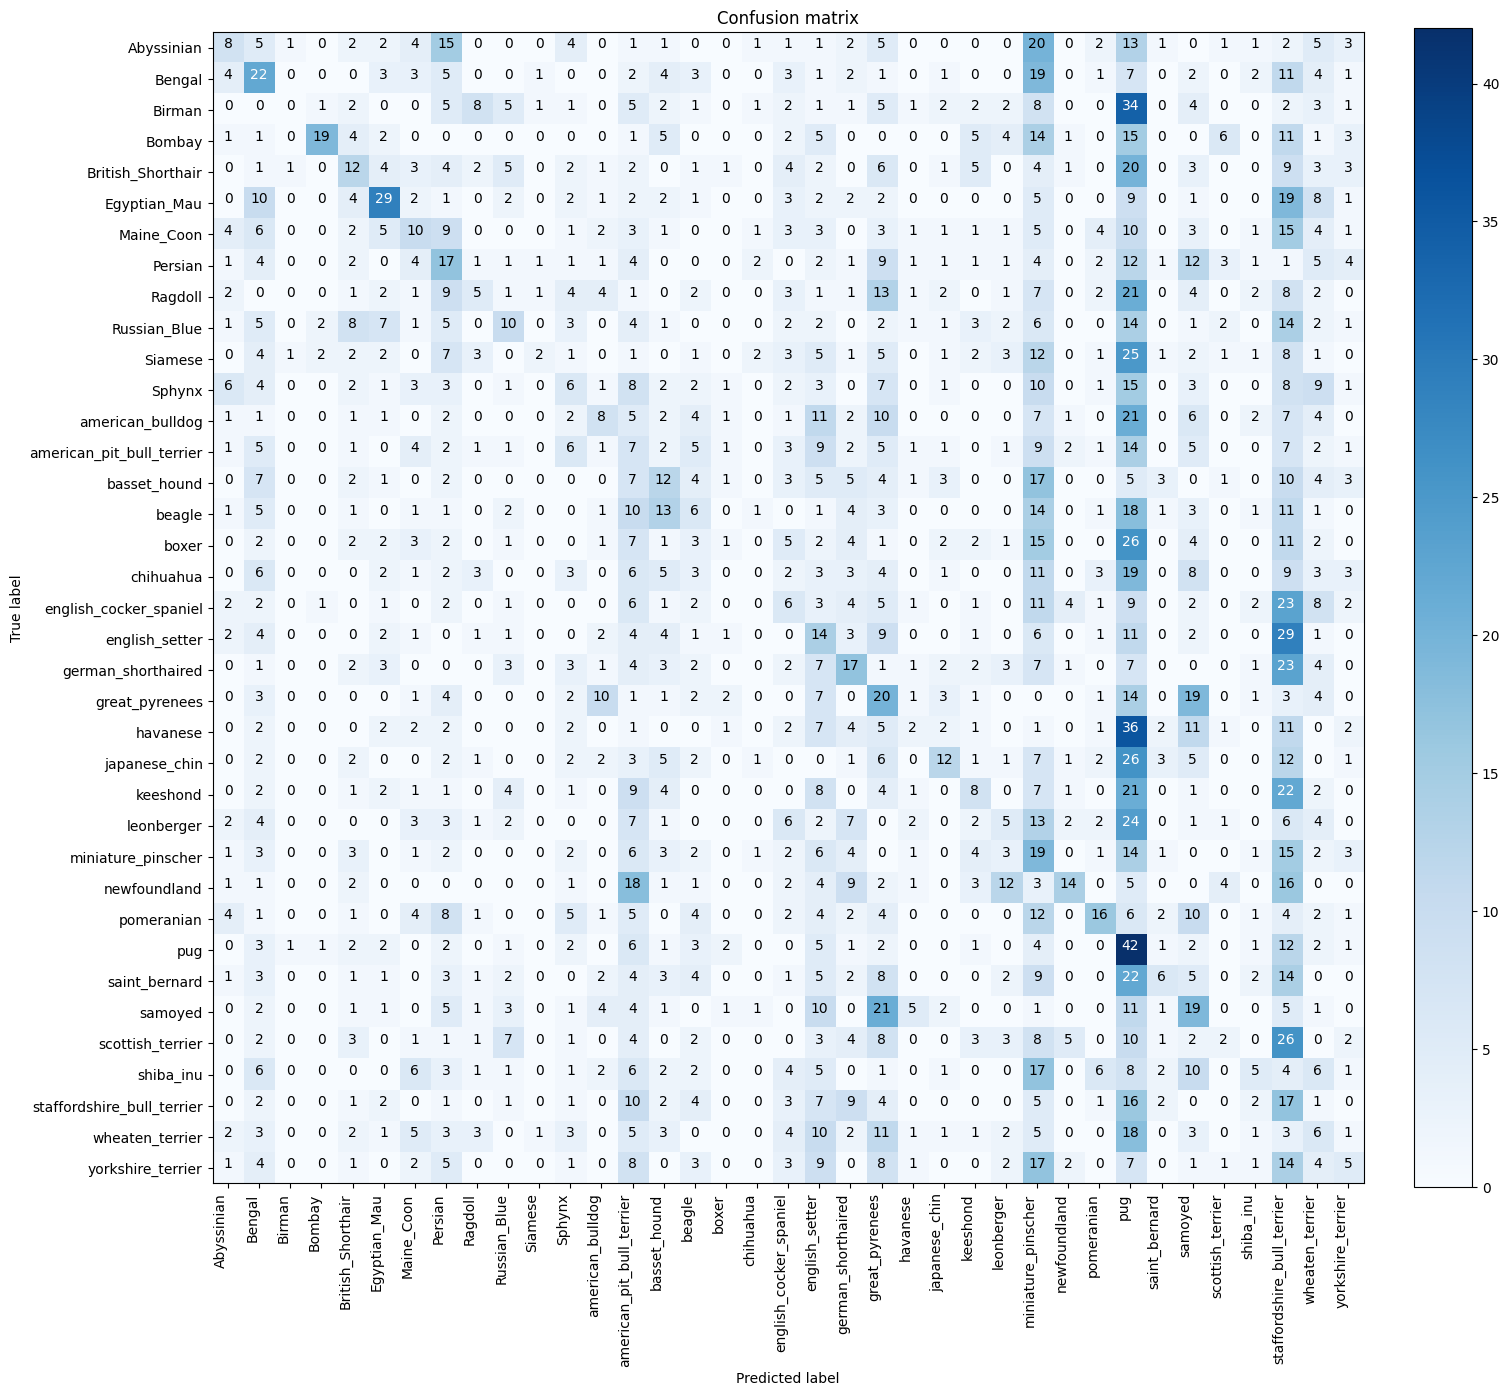

In [72]:
evaluate_multiclass(logbreedsCnnSimples, breedsCnnSimples, breedsTestGen, 'breedsCnnSimples')

##### 5.2.2 - With data augmentation

In [73]:
## CNN from scratch with data augmentation

breedsCnnAug = models.Sequential([
    layers.Conv2D(16, (5, 5), activation='relu', padding='same', input_shape=input_shape),
    layers.Conv2D(16, (3, 3), activation='relu', padding='same'), #
    layers.AveragePooling2D((2, 2)),
    layers.Dropout(0.5),#
    layers.BatchNormalization(),#

    layers.Conv2D(32, (5, 5), activation='relu',  padding='same'), #
    layers.Conv2D(32, (3, 3), activation='relu',  padding='same'), #
    layers.AveragePooling2D((2, 2)),
    layers.Dropout(0.5),#
    layers.BatchNormalization(),#

    layers.Conv2D(32, (3, 3), activation='relu',  padding='same'), #
    layers.Conv2D(32, (3, 3), activation='relu',  padding='same'),
    layers.AveragePooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(37, activation='softmax') # 37 breeds


])


breedsCnnAug.compile(optimizer= "nadam", loss='categorical_crossentropy', metrics=['accuracy'])

print(breedsCnnAug.summary())


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 224, 224, 16)      1216      
                                                                 
 conv2d_18 (Conv2D)          (None, 224, 224, 16)      2320      
                                                                 
 average_pooling2d_9 (Averag  (None, 112, 112, 16)     0         
 ePooling2D)                                                     
                                                                 
 dropout_6 (Dropout)         (None, 112, 112, 16)      0         
                                                                 
 batch_normalization_5 (Batc  (None, 112, 112, 16)     64        
 hNormalization)                                                 
                                                                 
 conv2d_19 (Conv2D)          (None, 112, 112, 32)     

In [74]:
%%time
best_breedsCnnAug = os.path.join(folder, 'best_breedsCnnAug.h5')

#early_stop = keras.callbacks.EarlyStopping(monitor='accuracy', patience=10)
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                           patience=5, 
                                           restore_best_weights=True)

best_model = keras.callbacks.ModelCheckpoint(best_breedsCnnAug, 
                                             monitor='val_loss', 
                                             save_best_only=True)

logbreedsCnnAug = breedsCnnAug.fit(breedsTrainGenAug,
                    epochs=30,
                    validation_data=breedsTestGen,
                    callbacks=[early_stop, best_model])

# loaded_model = load_model(best_breedsCnnAug)

Epoch 1/30
116/116 [==============================] - 28s 235ms/step - loss: 3.6508 - accuracy: 0.0228 - val_loss: 3.6109 - val_accuracy: 0.0270
Epoch 2/30
116/116 [==============================] - 26s 227ms/step - loss: 3.6114 - accuracy: 0.0182 - val_loss: 3.6109 - val_accuracy: 0.0270
Epoch 3/30
116/116 [==============================] - 26s 221ms/step - loss: 3.6114 - accuracy: 0.0222 - val_loss: 3.6110 - val_accuracy: 0.0270
Epoch 4/30
116/116 [==============================] - 26s 222ms/step - loss: 3.6113 - accuracy: 0.0209 - val_loss: 3.6110 - val_accuracy: 0.0270
Epoch 5/30
116/116 [==============================] - 26s 221ms/step - loss: 3.6114 - accuracy: 0.0225 - val_loss: 3.6110 - val_accuracy: 0.0270
Epoch 6/30
116/116 [==============================] - 26s 221ms/step - loss: 3.6113 - accuracy: 0.0214 - val_loss: 3.6110 - val_accuracy: 0.0270
CPU times: total: 2min 58s
Wall time: 2min 37s


116/116 [==============================] - 4s 36ms/step
              Accuracy  N. Erros  Precision  Recall  F1-score
breedsCnnAug      0.03      3604        0.0    0.03       0.0


CLASSIFICATION REPORT

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       101
           1       0.00      0.00      0.00       102
           2       0.00      0.00      0.00       100
           3       0.00      0.00      0.00       100
           4       0.00      0.00      0.00       100
           5       0.00      0.00      0.00       108
           6       0.00      0.00      0.00       100
           7       0.00      0.00      0.00       100
           8       0.00      0.00      0.00       101
           9       0.00      0.00      0.00       100
          10       0.00      0.00      0.00       100
          11       0.00      0.00      0.00       100
          12       0.00      0.00      0.00       100
          13       0.00      0.00     

C:\Users\goncalo\aaa\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\goncalo\aaa\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\goncalo\aaa\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\goncalo\aaa\venv\lib\site-packages\sklearn\metrics\_clas

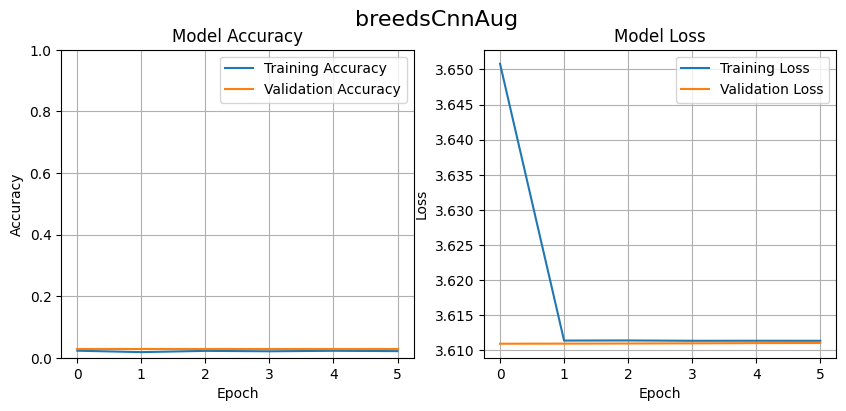

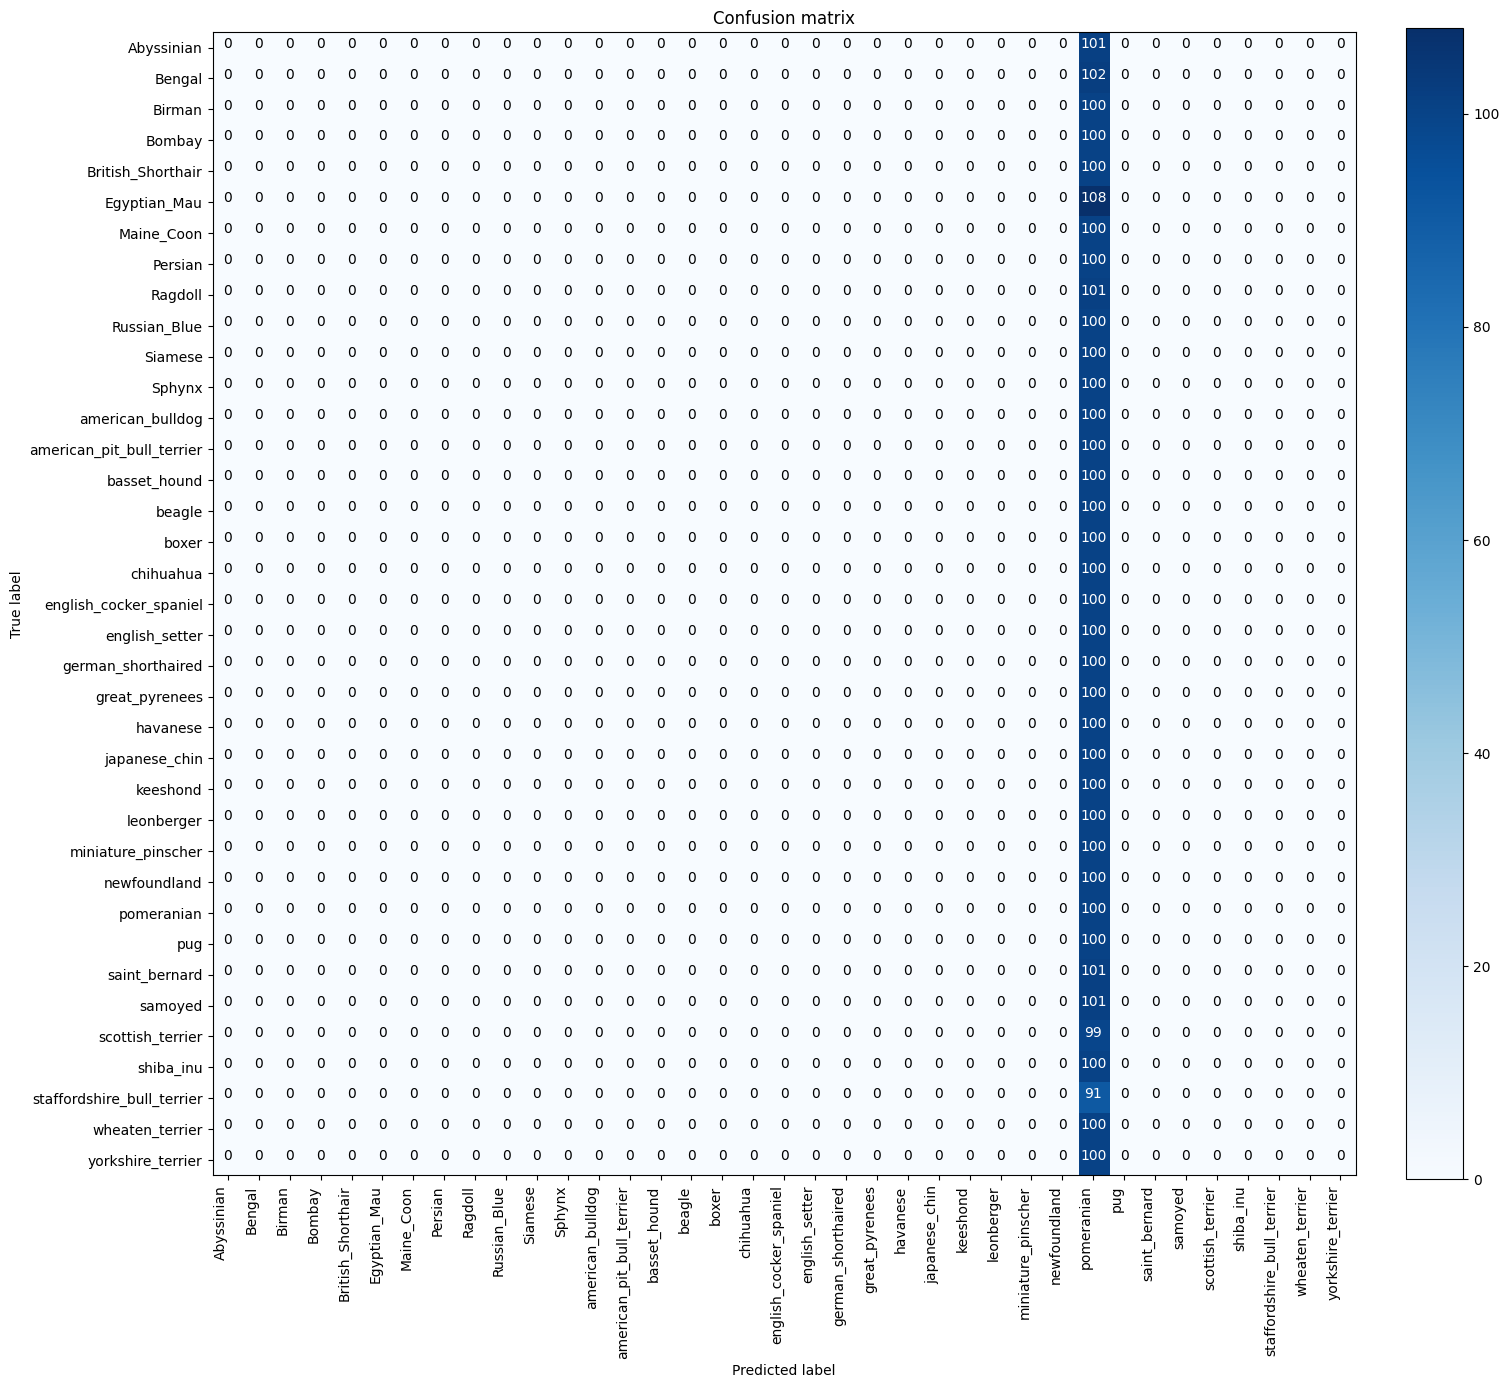

In [75]:

evaluate_multiclass(logbreedsCnnAug, breedsCnnAug, breedsTestGen, 'breedsCnnAug')

In [76]:
# treinar rede mais simples
breedsCnnSimplesAug = models.Sequential([
    layers.Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=input_shape),
    layers.MaxPool2D((2, 2)),
    layers.Dropout(0.3),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPool2D((2, 2)),
    # Flatten(),
    layers.Flatten(),
    layers.Dense(37, activation='softmax'), # 37 classes

])

breedsCnnSimplesAug.compile(optimizer= "nadam", loss='categorical_crossentropy', metrics=['accuracy'])

print(breedsCnnSimplesAug.summary())

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_23 (Conv2D)          (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 112, 112, 16)     0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 112, 112, 16)      0         
                                                                 
 conv2d_24 (Conv2D)          (None, 110, 110, 64)      9280      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 55, 55, 64)       0         
 2D)                                                             
                                                                 
 flatten_8 (Flatten)         (None, 193600)           

In [77]:
%%time
## CNN from scratch without data augmentation

best_breedsCnnSimplesAug = os.path.join(folder, 'best_breedsCnnSimplesAug.h5')

#early_stop = keras.callbacks.EarlyStopping(monitor='accuracy', patience=10)
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                           patience=5, 
                                           restore_best_weights=True)

best_model = keras.callbacks.ModelCheckpoint(best_breedsCnnSimplesAug, 
                                             monitor='val_loss', 
                                             save_best_only=True)

logbreedsCnnSimples = breedsCnnSimplesAug.fit(breedsTrainGenAug,
                    epochs=30,
                    validation_data=breedsTestGen,
                    callbacks=[early_stop, best_model])

# loaded_model = load_model(best_breedsCnnSimplesAug)

Epoch 1/30
116/116 [==============================] - 27s 227ms/step - loss: 4.7089 - accuracy: 0.0567 - val_loss: 3.4931 - val_accuracy: 0.0886
Epoch 2/30
116/116 [==============================] - 26s 224ms/step - loss: 3.3663 - accuracy: 0.0950 - val_loss: 3.4162 - val_accuracy: 0.0985
Epoch 3/30
116/116 [==============================] - 26s 225ms/step - loss: 3.2516 - accuracy: 0.1305 - val_loss: 3.3621 - val_accuracy: 0.1142
Epoch 4/30
116/116 [==============================] - 26s 223ms/step - loss: 3.1887 - accuracy: 0.1348 - val_loss: 3.3298 - val_accuracy: 0.1126
Epoch 5/30
116/116 [==============================] - 26s 224ms/step - loss: 3.1295 - accuracy: 0.1503 - val_loss: 3.2760 - val_accuracy: 0.1247
Epoch 6/30
116/116 [==============================] - 27s 232ms/step - loss: 3.0667 - accuracy: 0.1552 - val_loss: 3.2660 - val_accuracy: 0.1239
Epoch 7/30
116/116 [==============================] - 26s 229ms/step - loss: 2.9936 - accuracy: 0.1785 - val_loss: 3.2401 - val_ac

116/116 [==============================] - 4s 36ms/step
                     Accuracy  N. Erros  Precision  Recall  F1-score
breedsCnnSimplesAug      0.17      3058       0.21    0.17      0.17


CLASSIFICATION REPORT

              precision    recall  f1-score   support

           0       0.15      0.16      0.15       101
           1       0.43      0.26      0.33       102
           2       0.23      0.08      0.12       100
           3       0.49      0.40      0.44       100
           4       0.22      0.22      0.22       100
           5       0.39      0.38      0.38       108
           6       0.15      0.16      0.15       100
           7       0.16      0.09      0.12       100
           8       0.31      0.15      0.20       101
           9       0.19      0.26      0.22       100
          10       0.16      0.06      0.09       100
          11       0.21      0.18      0.19       100
          12       0.35      0.07      0.12       100
          13       0.05 

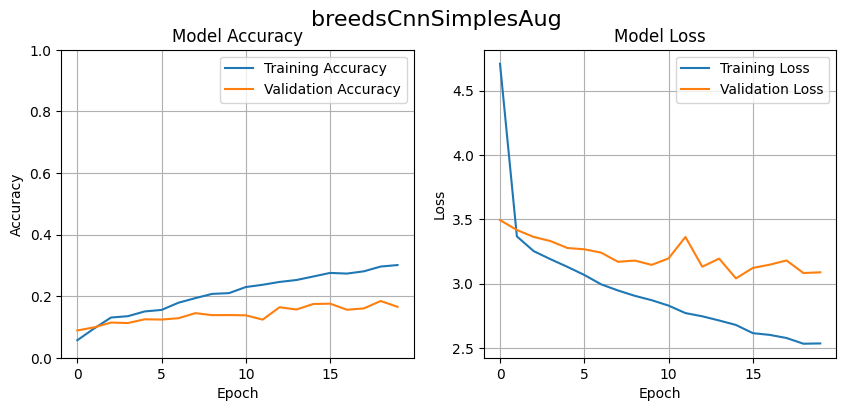

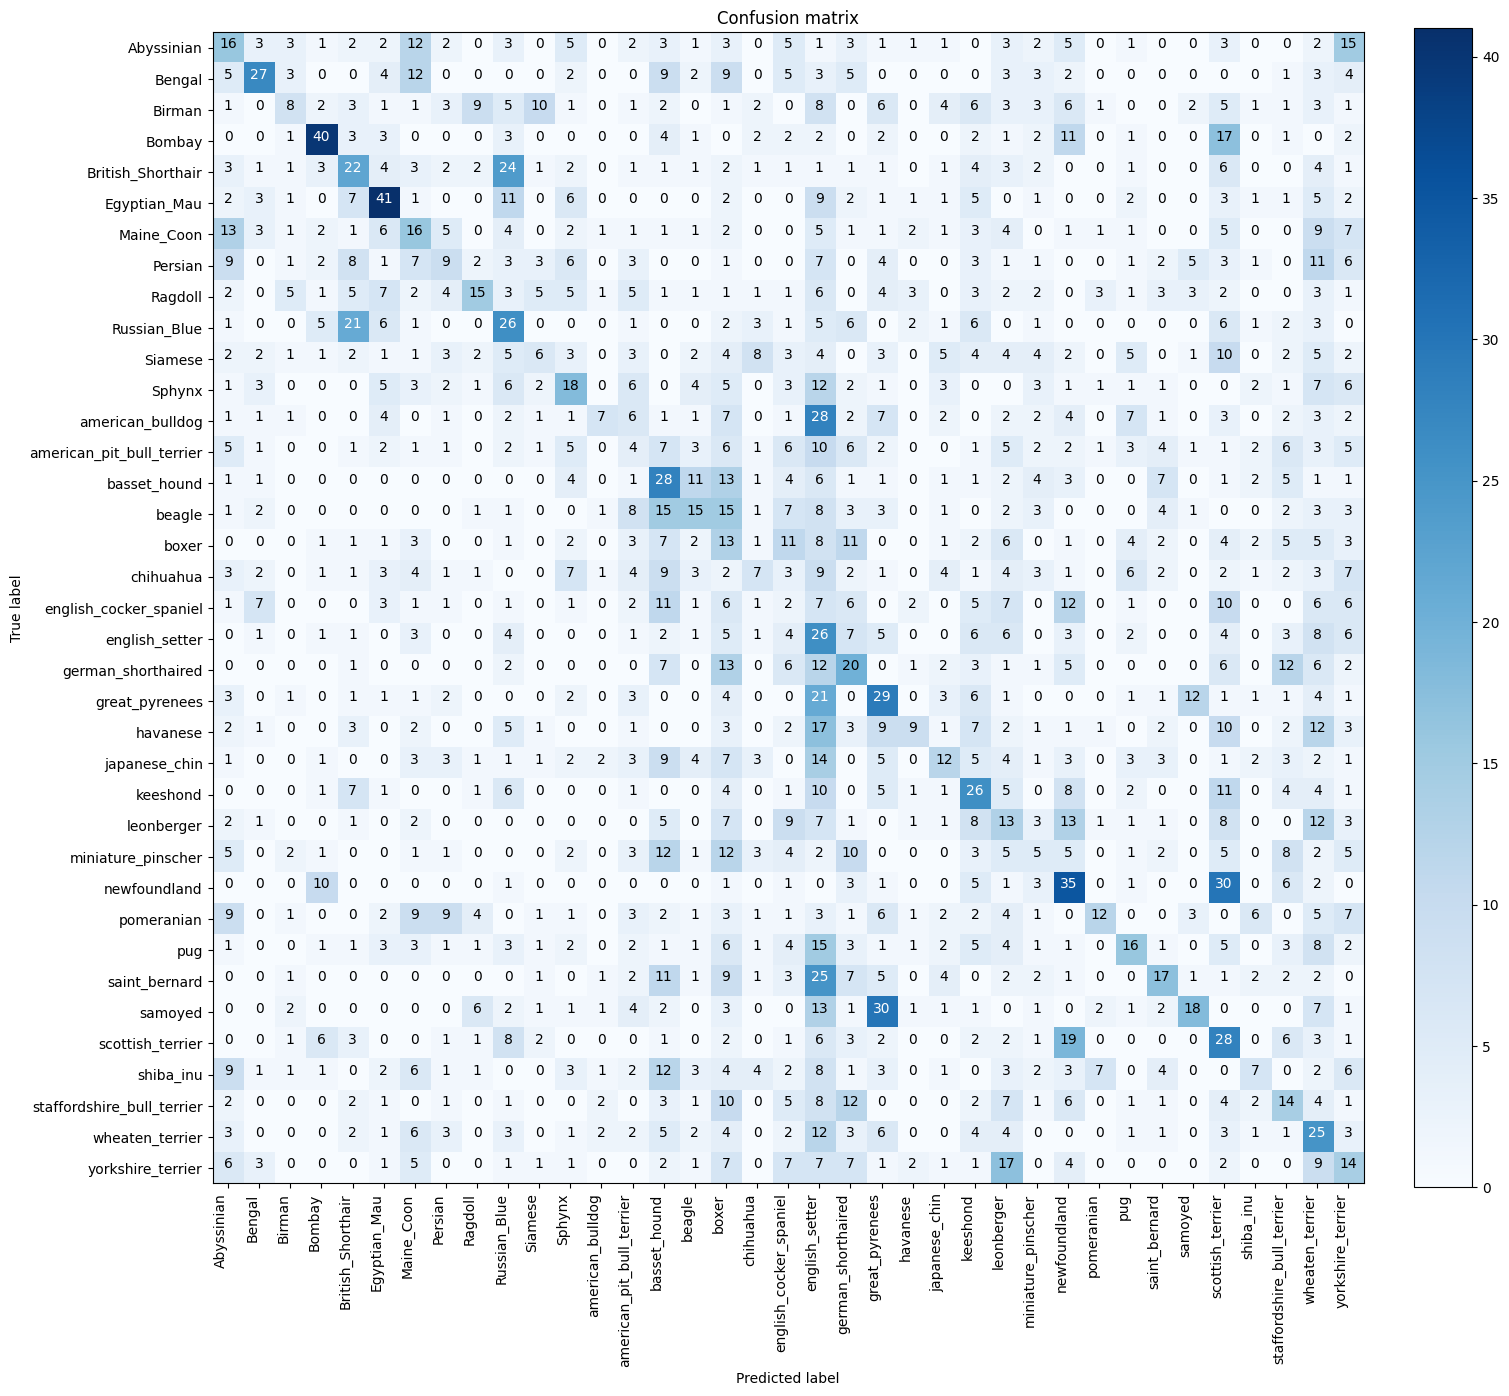

In [78]:
# Metricas
evaluate_multiclass(logbreedsCnnSimples, breedsCnnSimplesAug, breedsTestGen, 'breedsCnnSimplesAug')

#### CNN from pre-trained models

##### 5.2.1 - Without data augmentation 5.2.1 - Without data augmentation

- MobileNetV2

In [79]:
## Com MobileNetV2 network without data augmentation
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input

mn2 = MobileNetV2(weights='imagenet',
                  input_shape=(224, 224, 3))

mn2.trainable = False

#mn2.summary()

breedsMn2Cnn = models.Sequential()
breedsMn2Cnn.add(mn2)
breedsMn2Cnn.add(layers.Flatten())
breedsMn2Cnn.add(layers.Dense(64))
breedsMn2Cnn.add(layers.Dense(37, activation='softmax'))  # 37 breeds

breedsMn2Cnn.summary()

breedsMn2Cnn.compile(optimizer="nadam",
                     loss="categorical_crossentropy",
                     metrics=["accuracy"])


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 1000)             3538984   
 ional)                                                          
                                                                 
 flatten_9 (Flatten)         (None, 1000)              0         
                                                                 
 dense_14 (Dense)            (None, 64)                64064     
                                                                 
 dense_15 (Dense)            (None, 37)                2405      
                                                                 
Total params: 3,605,453
Trainable params: 66,469
Non-trainable params: 3,538,984
_________________________________________________________________


In [80]:
%%time
## CNN from scratch without data augmentation
best_breedsMn2Cnn = os.path.join(folder, 'best_breedsMn2Cnn.h5')

#early_stop = keras.callbacks.EarlyStopping(monitor='accuracy', patience=10)
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                           patience=5, 
                                           restore_best_weights=True)

best_model = keras.callbacks.ModelCheckpoint(best_breedsMn2Cnn, 
                                             monitor='val_loss', 
                                             save_best_only=True)

logbreedsMn2Cnn = breedsMn2Cnn.fit(breedsTrainGen,
                       epochs=30,
                       validation_data=breedsTestGen,
                       callbacks=[early_stop, best_model])

# loaded_model = load_model(best_breedsMn2Cnn)

Epoch 1/30
116/116 [==============================] - 11s 79ms/step - loss: 3.3852 - accuracy: 0.5884 - val_loss: 3.0484 - val_accuracy: 0.7360
Epoch 2/30
116/116 [==============================] - 9s 79ms/step - loss: 2.5772 - accuracy: 0.7260 - val_loss: 1.9545 - val_accuracy: 0.7314
Epoch 3/30
116/116 [==============================] - 9s 74ms/step - loss: 1.6009 - accuracy: 0.7317 - val_loss: 1.2223 - val_accuracy: 0.7462
Epoch 4/30
116/116 [==============================] - 9s 75ms/step - loss: 1.1287 - accuracy: 0.7472 - val_loss: 0.9600 - val_accuracy: 0.7594
Epoch 5/30
116/116 [==============================] - 9s 74ms/step - loss: 0.9376 - accuracy: 0.7645 - val_loss: 0.8463 - val_accuracy: 0.7694
Epoch 6/30
116/116 [==============================] - 9s 75ms/step - loss: 0.8370 - accuracy: 0.7697 - val_loss: 0.7841 - val_accuracy: 0.7732
Epoch 7/30
116/116 [==============================] - 9s 74ms/step - loss: 0.7745 - accuracy: 0.7827 - val_loss: 0.7478 - val_accuracy: 0.773

116/116 [==============================] - 5s 37ms/step
              Accuracy  N. Erros  Precision  Recall  F1-score
breedsMn2Cnn      0.81       713       0.81    0.81      0.81


CLASSIFICATION REPORT

              precision    recall  f1-score   support

           0       0.47      0.29      0.36       101
           1       0.52      0.52      0.52       102
           2       0.72      0.52      0.60       100
           3       0.75      0.68      0.71       100
           4       0.67      0.48      0.56       100
           5       0.43      0.76      0.55       108
           6       0.74      0.73      0.74       100
           7       0.77      0.89      0.83       100
           8       0.65      0.53      0.59       101
           9       0.54      0.53      0.54       100
          10       0.68      0.88      0.77       100
          11       0.83      0.69      0.75       100
          12       0.67      0.53      0.59       100
          13       0.66      0.62     

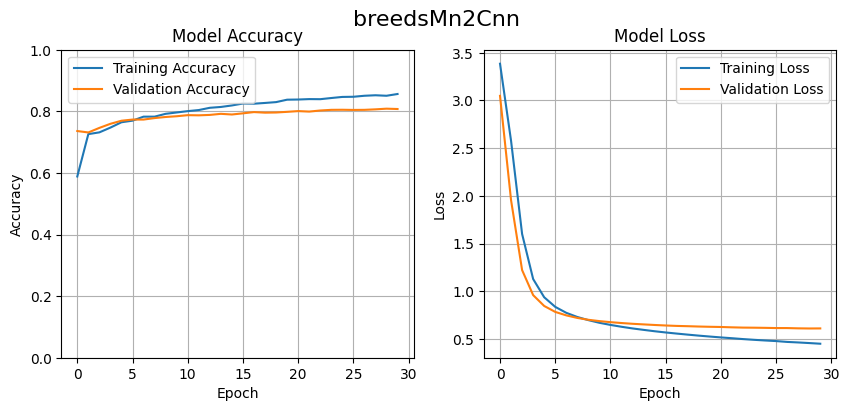

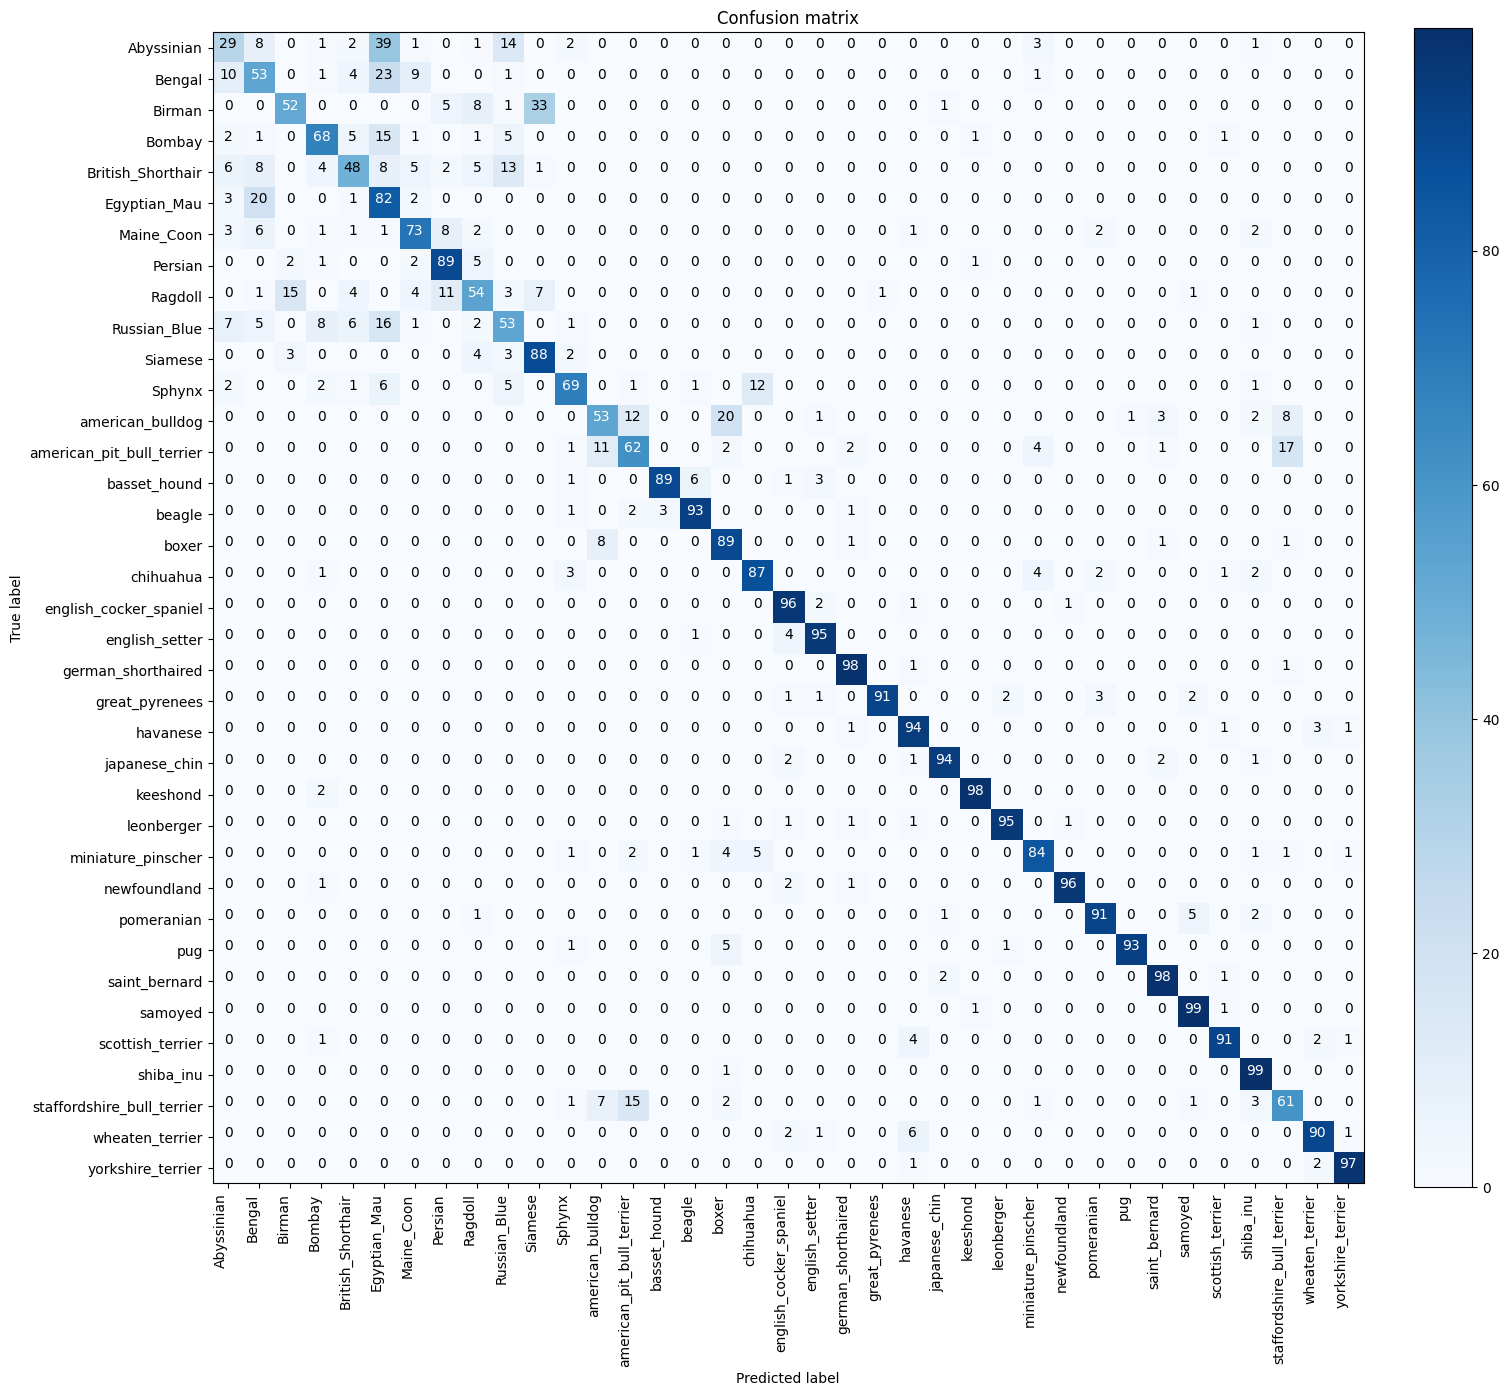

In [81]:
# Metricas
evaluate_multiclass(logbreedsMn2Cnn, breedsMn2Cnn, breedsTestGen, 'breedsMn2Cnn')

##### 5.2.1 - With data augmentation

- MobileNetV2

In [82]:
## Com MobileNetV2 network with data augmentation
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input

mn2aug = MobileNetV2(weights='imagenet',
                  input_shape=(224, 224, 3))

mn2aug.trainable = False

#mn2.summary()

breedsMn2CnnAug = models.Sequential()
breedsMn2CnnAug.add(mn2aug)
breedsMn2CnnAug.add(layers.Flatten())
breedsMn2CnnAug.add(layers.Dense(37, activation='softmax'))  # 37 breeds

breedsMn2CnnAug.summary()

breedsMn2CnnAug.compile(optimizer="nadam",
                     loss="categorical_crossentropy",
                     metrics=["accuracy"])

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 1000)             3538984   
 ional)                                                          
                                                                 
 flatten_10 (Flatten)        (None, 1000)              0         
                                                                 
 dense_16 (Dense)            (None, 37)                37037     
                                                                 
Total params: 3,576,021
Trainable params: 37,037
Non-trainable params: 3,538,984
_________________________________________________________________


In [83]:
%%time
## Com MobileNetV2 network With data augmentation
best_breedsMn2CnnAug = os.path.join(folder, 'best_breedsMn2CnnAug.h5')

#early_stop = keras.callbacks.EarlyStopping(monitor='accuracy', patience=10)
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                           patience=5, 
                                           restore_best_weights=True)

best_model = keras.callbacks.ModelCheckpoint(best_breedsMn2CnnAug, 
                                             monitor='val_loss', 
                                             save_best_only=True)

logbreedsMn2CnnAug = breedsMn2CnnAug.fit(breedsTrainGenAug,
                       epochs=30,
                       validation_data=breedsTestGen,
                       callbacks=[early_stop, best_model])

# loaded_model = load_model(best_breedsMn2CnnAug)


Epoch 1/30
116/116 [==============================] - 29s 238ms/step - loss: 3.5669 - accuracy: 0.3277 - val_loss: 3.5114 - val_accuracy: 0.5667
Epoch 2/30
116/116 [==============================] - 27s 236ms/step - loss: 3.4804 - accuracy: 0.5705 - val_loss: 3.4155 - val_accuracy: 0.6771
Epoch 3/30
116/116 [==============================] - 27s 237ms/step - loss: 3.3946 - accuracy: 0.6595 - val_loss: 3.3208 - val_accuracy: 0.7187
Epoch 4/30
116/116 [==============================] - 26s 226ms/step - loss: 3.3103 - accuracy: 0.7037 - val_loss: 3.2280 - val_accuracy: 0.7519
Epoch 5/30
116/116 [==============================] - 28s 239ms/step - loss: 3.2314 - accuracy: 0.7227 - val_loss: 3.1377 - val_accuracy: 0.7565
Epoch 6/30
116/116 [==============================] - 27s 232ms/step - loss: 3.1503 - accuracy: 0.7192 - val_loss: 3.0491 - val_accuracy: 0.7605
Epoch 7/30
116/116 [==============================] - 27s 235ms/step - loss: 3.0730 - accuracy: 0.7292 - val_loss: 2.9622 - val_ac

116/116 [==============================] - 5s 36ms/step
                 Accuracy  N. Erros  Precision  Recall  F1-score
breedsMn2CnnAug       0.8       758       0.82     0.8      0.79


CLASSIFICATION REPORT

              precision    recall  f1-score   support

           0       0.76      0.16      0.26       101
           1       0.42      0.63      0.50       102
           2       0.80      0.32      0.46       100
           3       0.77      0.60      0.67       100
           4       0.59      0.41      0.48       100
           5       0.36      0.77      0.49       108
           6       0.67      0.70      0.69       100
           7       0.70      0.90      0.79       100
           8       0.74      0.34      0.46       101
           9       0.64      0.27      0.38       100
          10       0.54      0.96      0.69       100
          11       0.84      0.65      0.73       100
          12       0.76      0.39      0.52       100
          13       0.65      0.6

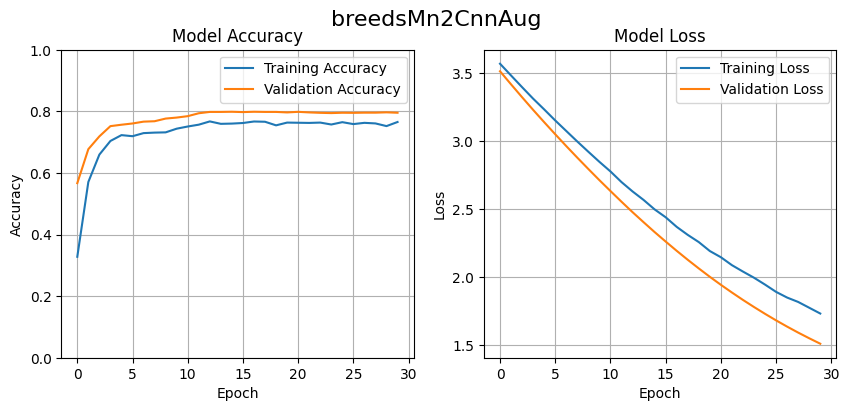

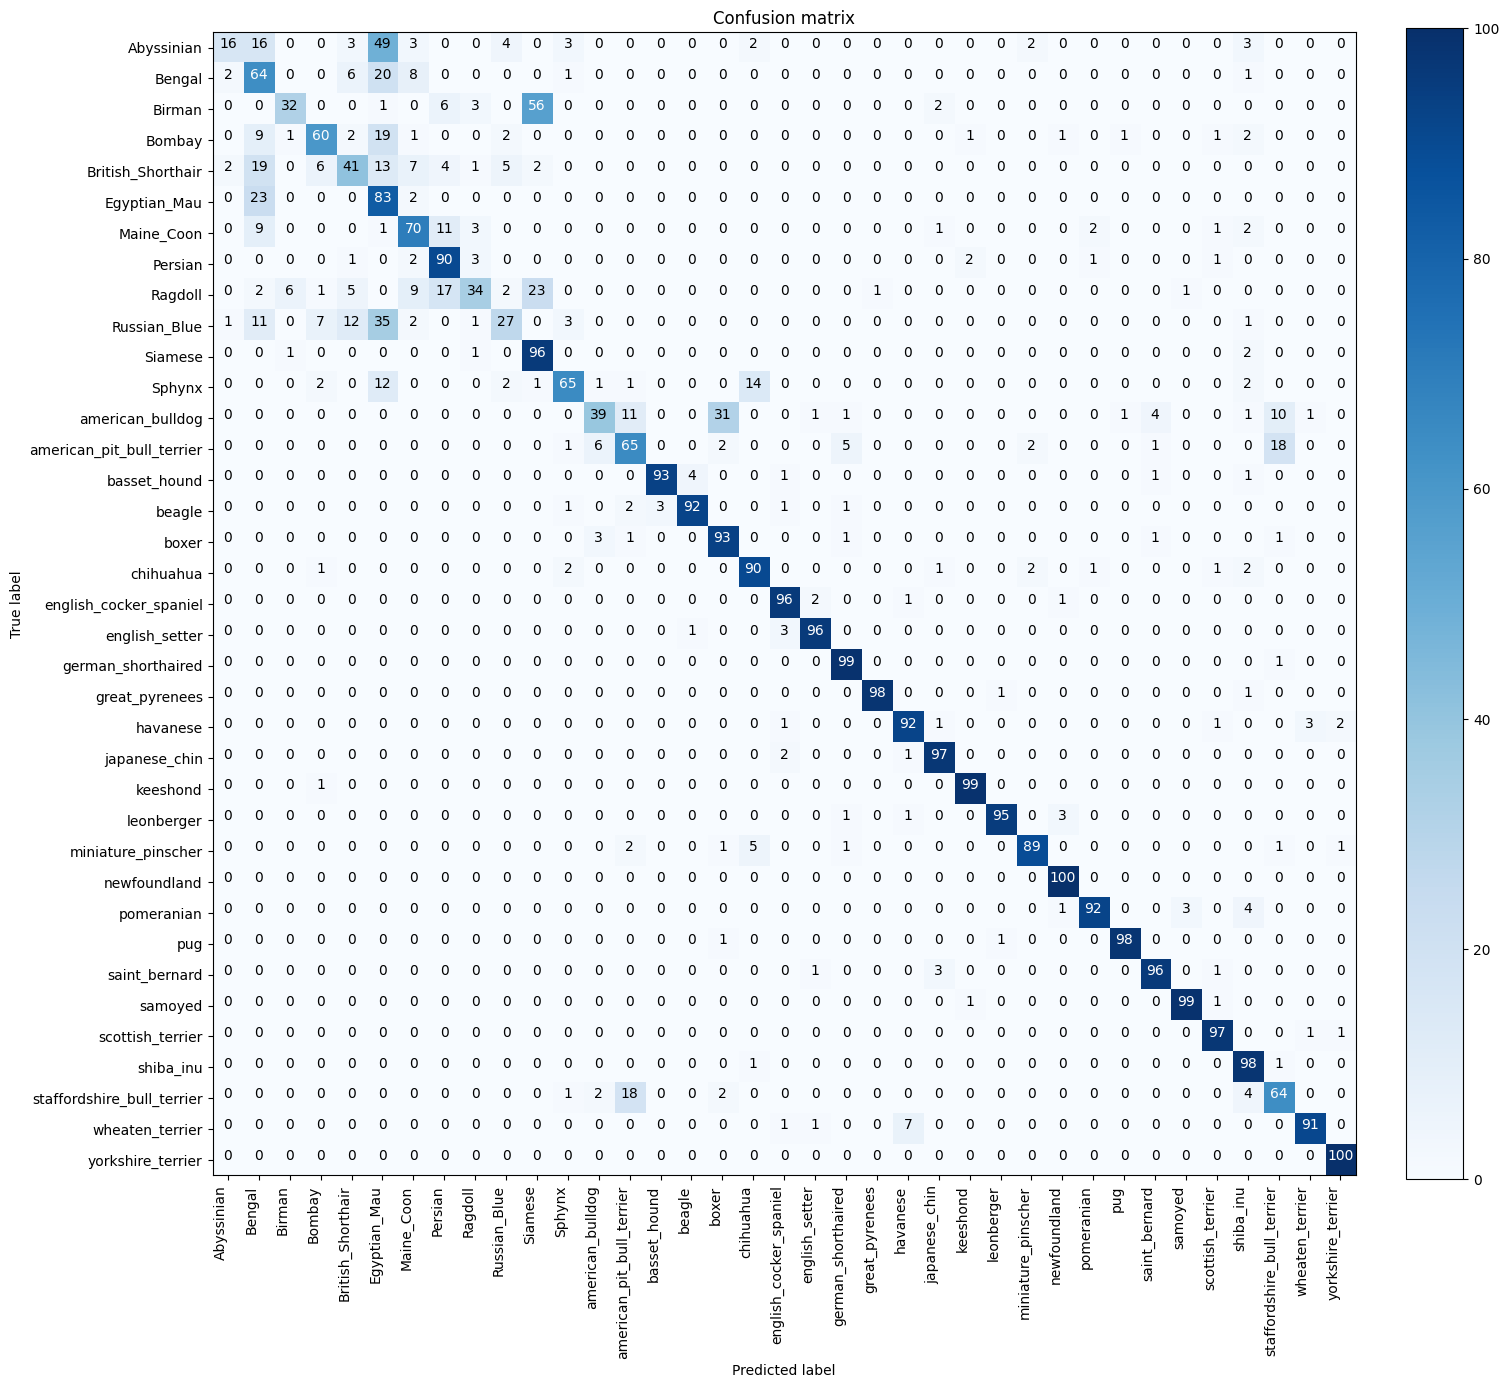

In [84]:
evaluate_multiclass(logbreedsMn2CnnAug, breedsMn2CnnAug, 
         breedsTestGen, 'breedsMn2CnnAug')

# Comparações

#### Comparacao na classificao binaria

116/116 [==============================] - 5s 39ms/step
            Accuracy  N. Erros  Precision  Recall  F1-score
speciesCnn      0.71      1060       0.76    0.84       0.8
116/116 [==============================] - 4s 36ms/step
               Accuracy  N. Erros  Precision  Recall  F1-score
speciesCnnAug      0.77       866       0.81    0.86      0.83
116/116 [==============================] - 4s 37ms/step
                    Accuracy  N. Erros  Precision  Recall  F1-score
species_binary_Cnn      0.98        58       0.98     1.0      0.99
116/116 [==============================] - 4s 37ms/step
                         Accuracy  N. Erros  Precision  Recall  F1-score
species_binary_Cnn_daug      0.98        71       0.97     1.0      0.99


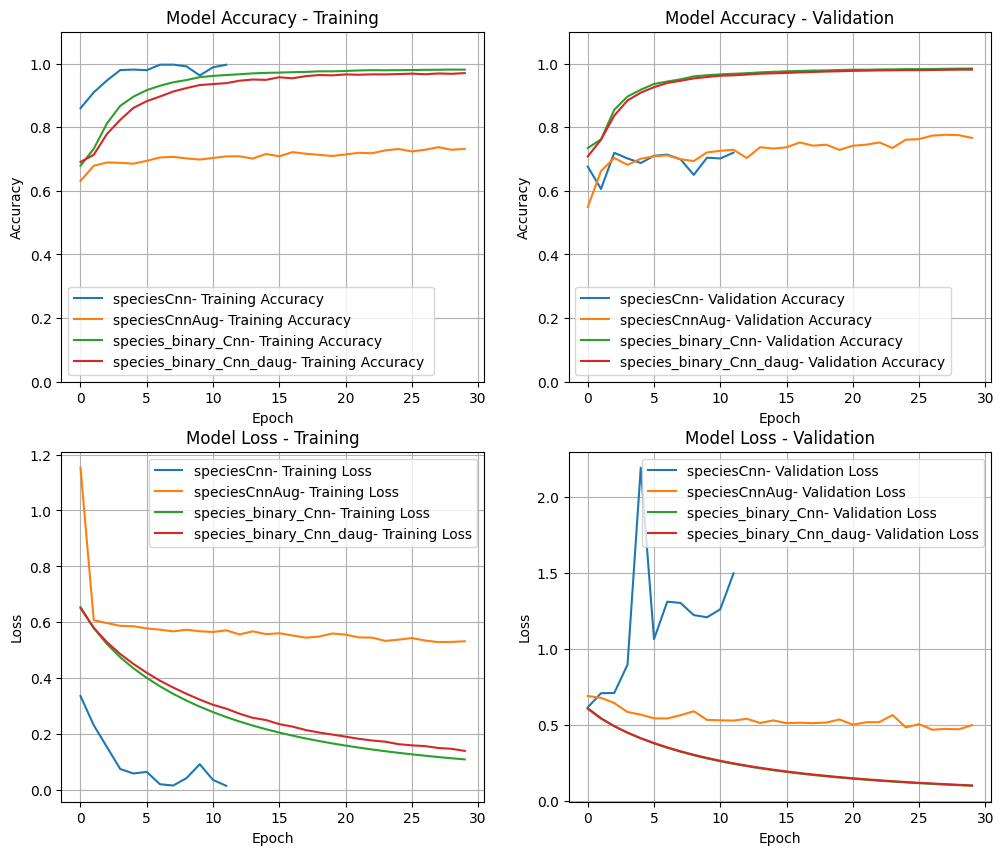

116/116 [==============================] - 4s 37ms/step
0.908778
116/116 [==============================] - 4s 36ms/step
0.60891014
116/116 [==============================] - 4s 37ms/step
0.72069913
116/116 [==============================] - 4s 36ms/step
0.7626653


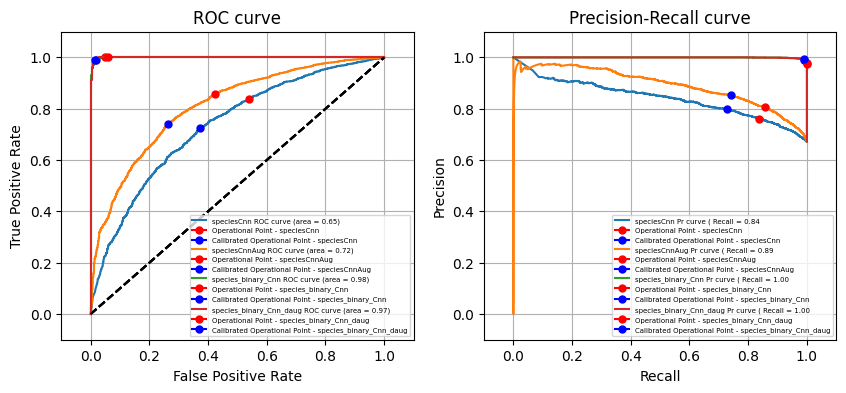

116/116 [==============================] - 4s 36ms/step


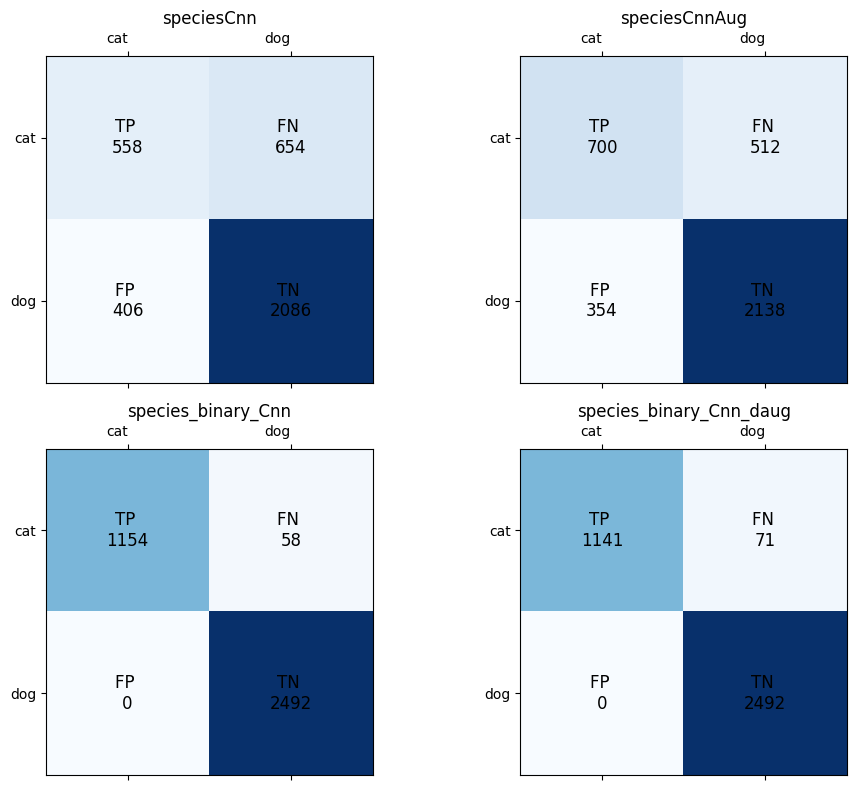

In [85]:
from tensorflow.keras.utils import to_categorical

def evaluates(logs, model, TestGen, nome_classificador):
    y_pred = model.predict(TestGen)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = TestGen.classes
    cm1 = confusion_matrix(y_true, y_pred_classes)

    metrics(y_true, y_pred_classes, nome_classificador)
    plot_history(logs.history, nome_classificador)


dict_models = {
    'speciesCnn': [logspeciesCnn, speciesCnn, speciesTestGen],
    'speciesCnnAug': [logspeciesCnnAug, speciesCnnAug, speciesTestGen],
    'species_binary_Cnn': [logspecies_binary_Cnn, species_binary_Cnn, speciesTestGen],
    'species_binary_Cnn_daug': [logspecies_binary_Cnn_daug, species_binary_Cnn_daug, speciesTestGen],
}

# PLOT HISTORY AND METRICS
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
acc_training = axes[0, 0]
acc_val = axes[0, 1]
loss_tran = axes[1, 0]
loss_val = axes[1, 1]
for model_name, (log, model, testGen) in dict_models.items():
    # print((log, model, testGen), model_name)
    # evaluates(log, model, testGen, model_name)

    y_pred = model.predict(testGen)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = testGen.classes

    metrics(y_true, y_pred_classes, model_name)


    h = log.history # verificar
    #fig.suptitle(model_name, fontsize=16)

    acc_training.plot(h['accuracy'], label=f'{model_name}- Training Accuracy ')
    acc_training.set_title('Model Accuracy - Training')
    acc_training.set_xlabel('Epoch')
    acc_training.set_ylabel('Accuracy')
    acc_training.legend()
    acc_training.grid(True)
    acc_training.set_ylim([0,1.1])
    
    #acc.plot(h['accuracy'], label=f'{model_name}- Training Accuracy ')
    acc_val.plot(h['val_accuracy'], label=f'{model_name}- Validation Accuracy')
    acc_val.set_title('Model Accuracy - Validation')
    acc_val.set_xlabel('Epoch')
    acc_val.set_ylabel('Accuracy')
    acc_val.legend()
    acc_val.grid(True)
    acc_val.set_ylim([0,1.1])
    # acc.set_xlim([0,epochs])
    # acc.axis([0,epochs,0,1])

    loss_tran.plot(h['loss'], label=f'{model_name}- Training Loss')
    loss_tran.set_title('Model Loss - Training')
    loss_tran.set_xlabel('Epoch')
    loss_tran.set_ylabel('Loss')
    loss_tran.legend()
    loss_tran.grid(True)

    #loss.plot(h['loss'], label=f'{model_name}- Training Loss')
    loss_val.plot(h['val_loss'], label=f'{model_name}- Validation Loss')
    loss_val.set_title('Model Loss - Validation')
    loss_val.set_xlabel('Epoch')
    loss_val.set_ylabel('Loss')
    loss_val.legend()
    loss_val.grid(True)
    # loss.set_xlim([0,epochs])
    # loss.axis([0,epochs])

plt.show()

# PLOT THE ROC AND PR
fig, (roc, pr) = plt.subplots(1, 2, figsize=(10, 4))
for model_name, (log, model, testGen) in dict_models.items():

    y_pred = model.predict(testGen)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_pred = np.max(y_pred, axis=1)
    for i, val in enumerate(y_pred_classes):
        if val == 0:
            y_pred[i] = 1 - y_pred[i]
    y_true = testGen.classes

    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred_classes)
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    pr_auc = auc(recall, precision)
    
    # add roc point and pr point
    cm1 = confusion_matrix(y_true, y_pred_classes)
    fpP1 = cm1[0,1]/(cm1[0,1]+cm1[0,0])
    tpP1 = cm1[1,1]/(cm1[1,1]+cm1[1,0])

    recallP1 = cm1[1,1]/(cm1[1,1]+cm1[1,0])
    precisionP1 = cm1[1,1]/(cm1[1,1]+cm1[0,1])

    threshold = thresholds[np.argmax(np.abs(fpr - tpr))]
    print(threshold)
    y2_pred2 = (y_pred > threshold)
    cm2 = confusion_matrix(y_true, y2_pred2)
    fpP2 = cm2[0,1]/(cm2[0,1]+cm2[0,0])
    tpP2 = cm2[1,1]/(cm2[1,1]+cm2[1,0])

    recallP2 = cm2[1,1]/(cm2[1,1]+cm2[1,0])
    precisionP2 = cm2[1,1]/(cm2[1,1]+cm2[0,1])

    # fig.suptitle(model_name, fontsize=16)

    roc.plot(fpr, tpr, 
             label=f'{model_name} ROC curve (area = {roc_auc:.2f})')
    roc.plot([0, 1], [0, 1], 'k--')

    roc.plot(fpP1, tpP1, marker='o', markersize=5, color="red", label='Operational Point - ' + model_name)
    roc.plot(fpP2, tpP2, marker='o', markersize=5, color="blue", label='Calibrated Operational Point - ' + model_name)
    # roc.annotate('FP1', xy=(fpP1, tpP1), xytext=(fpP1+0.1, tpP1-0.1),
    #                 arrowprops=dict(facecolor='red', shrink=0.05))
    
    roc.set_title('ROC curve')
    roc.set_xlabel('False Positive Rate')
    roc.set_ylabel('True Positive Rate')
    roc.legend(fontsize=5)
    roc.grid(True)
    roc.set_xlim([-0.1, 1.1])
    roc.set_ylim([-0.1, 1.1])

    pr.plot(recall, precision, 
            label=f'{model_name} Pr curve ( Recall = {pr_auc:.2f}')
    pr.plot(recallP1, precisionP1, marker='o', markersize=5, color="red", label='Operational Point - ' + model_name)
    pr.plot(recallP2, precisionP2, marker='o', markersize=5, color="blue", label='Calibrated Operational Point - ' + model_name)
    
    pr.set_title('Precision-Recall curve')
    pr.set_xlabel('Recall')
    pr.set_ylabel('Precision')
    pr.legend(fontsize=5)
    pr.grid(True)
    pr.set_xlim([-0.1, 1.1])
    pr.set_ylim([-0.1, 1.1])

plt.show()

# fig, axes = plt.subplots(1, len(dict_models.keys()), figsize=(10, 4))
classes=['dog', 'cat' ]


# PLOT THE CONFUSION MATRIXS
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.ravel()

# Iterate over the models and plot the confusion matrices
for idx, (model_name, (log, model, testGen)) in enumerate(dict_models.items()):
    y_pred = model.predict(testGen)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = testGen.classes
    cm = confusion_matrix(y_true, y_pred_classes)

    ax = axes[idx]
    ax.set_title(model_name, fontsize=12)
    ax.matshow(cm, cmap='Blues')
    ax.set_xticks(np.arange(len(testGen.class_indices)))
    ax.set_yticks(np.arange(len(testGen.class_indices)))
    ax.set_xticklabels(testGen.class_indices)
    ax.set_yticklabels(testGen.class_indices)

    for j in range(len(testGen.class_indices)):
        for k in range(len(testGen.class_indices)):
            if j == 1 and k == 1:
                text = f"TN \n{cm[j, k]}"
            if j == 1 and k == 0:
                text = f"FP \n{cm[j, k]}"
            if j == 0 and k == 1:
                text = f"FN \n{cm[j, k]}"
            if j == 0 and k == 0:
                text = f"TP \n{cm[j, k]}"

            ax.text(k, j, text, ha="center", va="center", 
                    color="black", 
                    fontsize=12)

    plt.setp(ax.get_xticklabels(), ha="right")

plt.tight_layout()
plt.show()


Como se pode observar nos resultados anteriores, os modelos pré-treinados foram os que tiveram melhores resultados em comparação com as redes neuronais criadas manualmente.

Enquanto que no modelo de rede neuronal manual, os dados aumentados (data augmentation) usados permitiram melhorias nos resultados, nos modelos pré-treinados a diferença foi mínima, tendo até o modelo sem estes dados tido menos erros na ultima corrida realizada.


#### Comparacao na classificao Multiclasse

116/116 [==============================] - 5s 41ms/step
           Accuracy  N. Erros  Precision  Recall  F1-score
breedsCnn      0.03      3604        0.0    0.03       0.0
  1/116 [..............................] - ETA: 6s

C:\Users\tiago\aaa\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


116/116 [==============================] - 5s 40ms/step
                  Accuracy  N. Erros  Precision  Recall  F1-score
breedsCnnSimples      0.11      3295       0.16    0.11      0.11
116/116 [==============================] - 5s 40ms/step
              Accuracy  N. Erros  Precision  Recall  F1-score
breedsCnnAug      0.03      3604        0.0    0.03       0.0
  2/116 [..............................] - ETA: 6s

C:\Users\tiago\aaa\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


116/116 [==============================] - 4s 38ms/step
                     Accuracy  N. Erros  Precision  Recall  F1-score
breedsCnnSimplesAug      0.17      3058       0.21    0.17      0.17
116/116 [==============================] - 4s 38ms/step
              Accuracy  N. Erros  Precision  Recall  F1-score
breedsMn2Cnn      0.81       713       0.81    0.81      0.81
116/116 [==============================] - 4s 38ms/step
                 Accuracy  N. Erros  Precision  Recall  F1-score
breedsMn2CnnAug       0.8       758       0.82     0.8      0.79


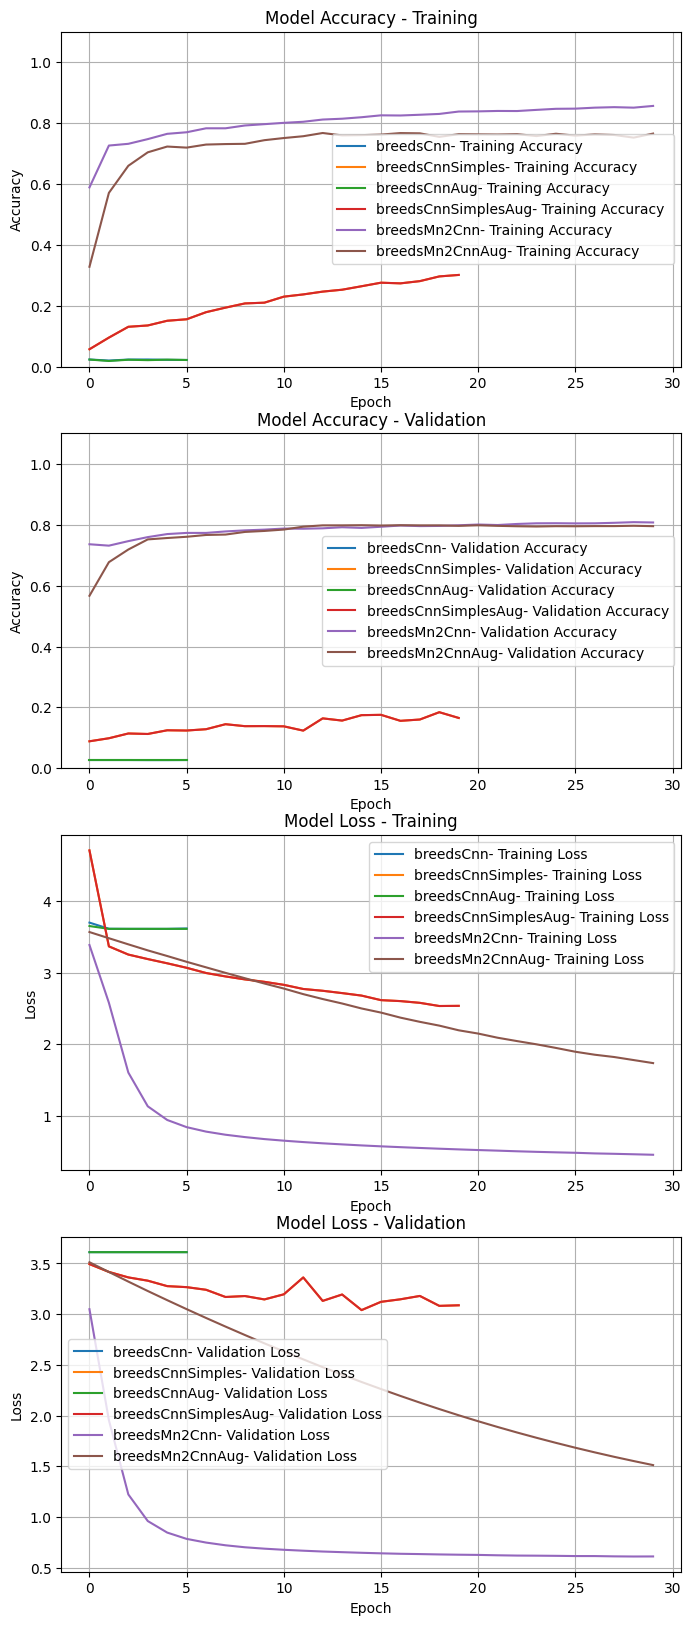

  4/116 [>.............................] - ETA: 5s

In [ ]:

dict_models = {
    'breedsCnn': [logbreedsCnn, breedsCnn, breedsTestGen],
    'breedsCnnSimples': [logbreedsCnnSimples, breedsCnnSimples, breedsTestGen],
    'breedsCnnAug': [logbreedsCnnAug, breedsCnn, breedsTestGen],
    'breedsCnnSimplesAug': [logbreedsCnnSimples, breedsCnnSimplesAug, breedsTestGen],
    'breedsMn2Cnn': [logbreedsMn2Cnn, breedsMn2Cnn, breedsTestGen],
    'breedsMn2CnnAug': [logbreedsMn2CnnAug, breedsMn2CnnAug, breedsTestGen],
}



# PLOT HISTORY AND METRICS
fig, axes = plt.subplots(4, 1, figsize=(8, 20))

acc_training = axes[0]
acc_val = axes[1]
loss_tran = axes[2]
loss_val = axes[3]
for model_name, (log, model, testGen) in dict_models.items():
    # print((log, model, testGen), model_name)
    # evaluates(log, model, testGen, model_name)

    y_pred = model.predict(testGen)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = testGen.classes

    #metrics(y_true, y_pred_classes, model_name)

    accuracy = accuracy_score(y_true, y_pred_classes)
    num_erros = len(y_true) - np.sum(y_true == y_pred_classes)
    precision = precision_score(y_true, y_pred_classes, average='macro')
    recall = recall_score(y_true, y_pred_classes, average='macro')
    f1 = f1_score(y_true, y_pred_classes, average='macro')

    # Criar o DataFrame
    df_metrics = pd.DataFrame({
        'Accuracy': [round(accuracy, 2)],
        'N. Erros': [num_erros],
        'Precision': [round(precision, 2)],
        'Recall': [round(recall, 2)],
        'F1-score': [round(f1, 2)]
    }, index=[model_name])

    # Imprimir o DataFrame
    print(df_metrics.head())


    h = log.history # verificar
    #fig.suptitle(model_name, fontsize=16)

    acc_training.plot(h['accuracy'], label=f'{model_name}- Training Accuracy ')
    acc_training.set_title('Model Accuracy - Training')
    acc_training.set_xlabel('Epoch')
    acc_training.set_ylabel('Accuracy')
    acc_training.legend()
    acc_training.grid(True)
    acc_training.set_ylim([0,1.1])

    acc_val.plot(h['val_accuracy'], label=f'{model_name}- Validation Accuracy')
    acc_val.set_title('Model Accuracy - Validation')
    acc_val.set_xlabel('Epoch')
    acc_val.set_ylabel('Accuracy')
    acc_val.legend()
    acc_val.grid(True)
    acc_val.set_ylim([0,1.1])
    # acc.set_xlim([0,epochs])
    # acc.axis([0,epochs,0,1])

    loss_tran.plot(h['loss'], label=f'{model_name}- Training Loss')
    loss_tran.set_title('Model Loss - Training')
    loss_tran.set_xlabel('Epoch')
    loss_tran.set_ylabel('Loss')
    loss_tran.legend()
    loss_tran.grid(True)



    loss_val.plot(h['val_loss'], label=f'{model_name}- Validation Loss')
    loss_val.set_title('Model Loss - Validation')
    loss_val.set_xlabel('Epoch')
    loss_val.set_ylabel('Loss')
    loss_val.legend()
    loss_val.grid(True)
    # loss.set_xlim([0,epochs])
    # loss.axis([0,epochs])

plt.show()


# fig, axes = plt.subplots(1, len(dict_models.keys()), figsize=(10, 4))

# PLOT THE CONFUSION MATRIXS
for model_name, (log, model, testGen) in dict_models.items():
    y_pred = model.predict(testGen)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = testGen.classes
    cm = confusion_matrix(y_true, y_pred_classes)


    plot_confusion_matrix_multiclass(cm, testGen.class_indices, title="Confusion matrix - " + model_name)

Comecou-se por utilizar o modelo breedsCnn. No entanto, este modelo teve resultados mais pobres, o que levou à criação de um modelo mais simples (breedsCnnSimples), em que se obteve melhores resultados. No entanto, estes resultados também não foram muito bons (11%), melhorando os resultados do modelo Simples para 17% com os dados aumentados (data augumentation).

Comparandos os modelos referidos anteriormente com os modelos pré-treinados, os modelos pré-treinados tiveram resultados substâncialmente melhores, chegando mesmo até aos 80%. Também, tal como os modelos pré-treinados nos binários, os dados aumentados (augmented data) não levaram a uma melhoria dos modelos, mesmo até piorando o modelo (com diferenças mínimas).




# Conclusion

| Strategy       | W/Augmentation | pre-trained | Score  | Number of Errors | Precision | Recall | F1-Score | N.Parametros treinaveis | Total Parametros | Time |
| ---            | ---            | ---         | ---    | ---              | ---       | ---    | ---      | ---                     | --- | --- |
| BINARY          |             |          |     |               |        |     |       |                      |  |  |
| - speciesCnn     |                |             | 69%    | 1133   | 0.80      | 0.73   | 0.76     | 11,088,914   | 11,088,946 | 1m46s |
| - species_binary_Cnn |            | MobileNetV2 | 99%    | 46     | 0.99      | 0.99   | 0.99     | 2,002        | 3,540,986 | 4m31s |
| - speciesCnnAug  | sim            |             | 74%    | 983    | 0.85      | 0.74   | 0.79     | 11,088,914   | 11,088,946 | 13m14s |
| - species_binary_Cnn_daug  | sim   | MobileNetV2 | 99%    | 45    | 0.99      | 0.99    | 0.99     | 2,002        | 3,540,986 | 13m17s |
| MULTICLASSE          |             |          |     |               |        |     |       |                      |  |  |
| - breedsCnn      |                |             | 3%     | 3604   | 0.00    | 0.03    | 0.00        | 848,277      | 848,373 | 1m09s |
| - breedsCnnSimples |                |           | 11%     | 3295   | 0.16    | 0.11    | 0.11        | 7,172,965      | 7,172,965 | 1m15s |
| - breedsCnnAug   | sim            |             | 3%     | 3604   | 0.00    | 0.03    | 0.00        | 848,277      | 848,373 | 2m37s |
| - breedsCnnSimplesAug |  sim      |             | 17%     | 3058   | 0.21    | 0.17    | 0.17        | 7,172,965      | 7,172,965 | 8m50s |
| - breedsMn2Cnn   |                | MobileNetV2 | 81% | 713 | 0.81    | 0.81    | 0.81      | 66,469 | 3,605,453 | 4m30s |
| - breedsMn2CnnAug| sim            | MobileNetV2 | 80% | 758 | 0.82    | 0.80    | 0.79     | 37,037 | 3,576,021 | 13m37s |

